In [2]:
import pandas as pd
import numpy as np
import sys
import os
from Bio.PDB import PDBParser, Polypeptide, PPBuilder
import tqdm
import glob
import matplotlib.pyplot as plt
import json
from sklearn.metrics import mean_squared_error
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sb
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import gaussian_kde, spearmanr
import os
import shutil
import subprocess
from collections import OrderedDict
from Bio.PDB import PDBParser, DSSP
import freesasa, Bio.PDB as PDB
from scipy.stats import wilcoxon, rankdata
import numpy as np


def compute_rasa(pdb_path, prefer='freesasa'):
    # 最大ASA表（例：Tien et al. の値の一部。実際は全20種を埋めて使う）
    ASA_MAX = {'ALA':129.0,'ARG':274.0,'ASN':195.0,'ASP':193.0,'CYS':167.0,
            'GLN':225.0,'GLU':223.0,'GLY':104.0,'HIS':224.0,'ILE':197.0,
            'LEU':201.0,'LYS':236.0,'MET':224.0,'PHE':240.0,'PRO':159.0,
            'SER':155.0,'THR':172.0,'TRP':285.0,'TYR':263.0,'VAL':174.0}

    pdb = pdb_path
    structure = freesasa.Structure(pdb)
    result = freesasa.calc(structure)
    rsa = result.residueAreas()  # {(chain, resn, resi): areas}

    # Biopythonで残基巡回し、rASAテーブルを作成
    parser = PDB.PDBParser(QUIET=True)
    model = parser.get_structure('X', pdb)[0]
    rasa_per_res = {}
    for chain in model:
        for res in chain:
            resn = res.get_resname()
            resi = res.id[1]
            
            asa = rsa[chain.id][str(resi)].total  # Å^2
            rasa = asa / ASA_MAX[resn]
            rasa_per_res[res.id[1]] = rasa

    return rasa_per_res


def get_sequence_from_single_chain_pdb(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    ppb = PPBuilder()
    
    # 最初のモデル・最初のチェーンから抽出
    model = structure[0]
    chain = list(model.get_chains())[0]
    
    # 一つのペプチド鎖として構築
    sequence = ppb.build_peptides(chain)[0].get_sequence()
    return str(sequence)

def get_pLDDT(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)
    pLDDT_scores = []
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    b_factor = residue['CA'].get_bfactor()
                    pLDDT_scores.append(b_factor)
    
    if pLDDT_scores:
        return np.mean(pLDDT_scores)
    else:
        return None

In [3]:
model_name = 'RINAMI'

In [4]:
pred_dG_data = json.load(open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/likelihood_data/Mega_mt_pdb_test.json'))
pred_dG_data_wt_only = json.load(open('/Users/tomitanaoki/Desktop/Projects/dG_predictor/processed_data/likelihood_data/mega_wt.json'))
pred_dG_data_maxwell_kogadesign = json.load(open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/likelihood_data/maxwell_and_Koga_design_pdb.json'))

df_Koga_design = pd.read_csv('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/csv/Koga_design.csv')
id_to_dg_Koga_design = {}
for name, dg in zip(df_Koga_design['id'], df_Koga_design['dg']):
    id_to_dg_Koga_design[name] = dg
    
df_maxwell = pd.read_csv('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/csv/maxwell2007_sequences.csv')
id_to_dg_maxwell = {}
for name, dg in zip(df_maxwell['id'], df_maxwell['dg']):
    id_to_dg_maxwell[name] = dg*0.239006

df_train = pd.read_csv('/Users/tomitanaoki/Desktop/Projects/dG_predictor/processed_data/csv/mega_train.csv')
df_test = pd.read_csv('/Users/tomitanaoki/Desktop/Projects/dG_predictor/processed_data/csv/mega_test.csv')
df_val = pd.read_csv('/Users/tomitanaoki/Desktop/Projects/dG_predictor/processed_data/csv/mega_val.csv')

df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)




df_train = pd.read_csv('../processed_data/csv/mega_train.csv')
df_test = pd.read_csv('../processed_data/csv/mega_test.csv')
df_val = pd.read_csv('../processed_data/csv/mega_val.csv')
df_merge = pd.concat([df_train, df_test, df_val], ignore_index=True)

natural_npy_dir = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/rosetta_respective_score_data/'
natural_entire_score = []
for name in tqdm.tqdm(df_test['name']):
    npy_file = natural_npy_dir + name + '.npy'
    scores = np.load(npy_file)
    fa_sum_score = np.concatenate([scores[:,0:5], scores[:,6:7], scores[:,10:13]], axis=1)
    sum_scores = np.sum(scores, axis=(0, 1)) 
    natural_entire_score.append(sum_scores)

ESM_Fold_pdb_dir = '../processed_data/Mega_mt_pdb/'

pLDDT_list = []
dG_ML_list = []

for (name, dG) in tqdm.tqdm(zip(df_test['name'], df_test['dG_ML'])):
    pdb = ESM_Fold_pdb_dir + name + '.pdb'
    pLDDT = get_pLDDT(pdb)
    pLDDT_list.append(pLDDT)
    dG_ML_list.append(dG)


plddt_Mega_test = []
dG_exp_Mega_test = []

for name, dG in zip(df_test['name'], df_test['dG_ML']):
    pdb_path = f'../processed_data/Mega_mt_pdb/{name}.pdb'
    plddt = get_pLDDT(pdb_path)
    plddt_Mega_test.append(plddt)
    dG_exp_Mega_test.append(dG)



100%|██████████| 28312/28312 [00:08<00:00, 3423.95it/s]
28312it [01:51, 254.93it/s]


In [5]:
plddt_Maxwell = []
dG_exp_Maxwell = []

for name, dG in zip(df_test['name'], df_test['dG_ML']):
    pdb_path = f'../processed_data/Mega_mt_pdb/{name}.pdb'
    plddt = get_pLDDT(pdb_path)
    plddt_Mega_test.append(plddt)
    dG_exp_Mega_test.append(dG)


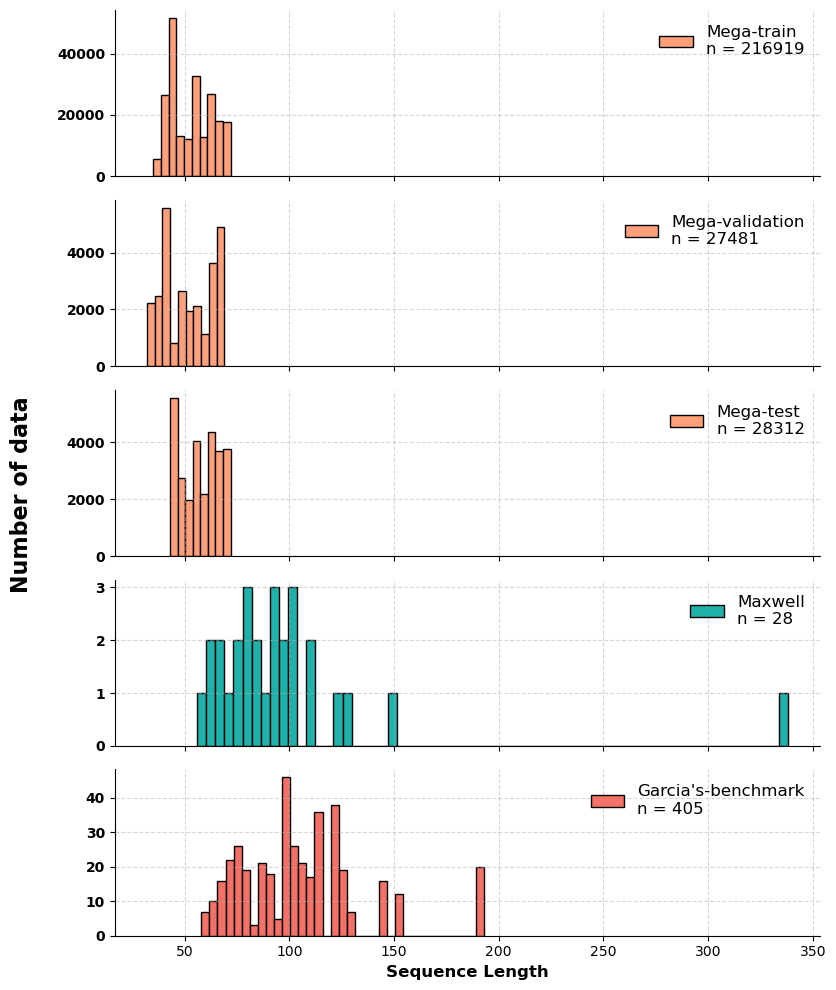

In [6]:
seq_len_Mega_train    = []
seq_len_Mega_val   = []
seq_len_Mega_test    = []
seq_len_maxwell = []
seq_len_Hydrophilic = []
seq_len_Rocklin = []

for seq in df_train['aa_seq']:
    seq_len_Mega_train.append(len(seq))
for seq in df_val['aa_seq']:
    seq_len_Mega_val.append(len(seq))
for seq in df_test['aa_seq']:
    seq_len_Mega_test.append(len(seq))
for seq in df_maxwell['sequence']:
    seq_len_maxwell.append(len(seq))
hydrophilic_test_f = open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/Hydrophilic_test_result.txt')
for line in hydrophilic_test_f:
    seq = line.split('=')[0].strip()
    seq_len_Hydrophilic.append(len(seq))
for line in open('../processed_data/fasta/Rocklin_zero_shot.fasta'):
    if line.startswith('>'):
        continue
    seq = line.strip()
    seq_len_Rocklin.append(len(seq))



data_lists = [seq_len_Mega_train, seq_len_Mega_val, seq_len_Mega_test, seq_len_maxwell, seq_len_Rocklin]


fig, axes = plt.subplots(nrows=len(data_lists), ncols=1, figsize=(8, 10), sharex=True)

for i, (bins, ax, color, dataset_label) in enumerate(zip([10, 10, 8, 65, 35], axes, ['#FFA07A', '#FFA07A', '#FFA07A', '#20B2AA', '#F37167'], [f'Mega-train\nn = {len(seq_len_Mega_train)}', f'Mega-validation\nn = {len(seq_len_Mega_val)}', f'Mega-test\nn = {len(seq_len_Mega_test)}', f'Maxwell\nn = {len(seq_len_maxwell)}', f'Garcia\'s-benchmark\nn = {len(seq_len_Rocklin)}'])):
    ax.hist(data_lists[i], bins=bins, color=color, edgecolor='black', density=False, label=dataset_label)

    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=12, frameon=False)

# x軸ラベル（共通）
axes[-1].set_xlabel("Sequence Length", fontsize=12, fontweight='bold')
#axes[-1].set_xticklabels([30, 80, 130, 180, 230, 280, 330, 380],fontsize=10, fontweight='bold')
fig.tight_layout()
sns.despine()
fig.text(-0.04, 0.5, "Number of data", va='center', rotation='vertical', fontsize=16, fontweight='bold')
#plt.ylabel("Number of data", fontsize=12, fontweight='bold')

plt.savefig('../Figures/Histgram_Sequence_length_comparison_datanum.png', dpi=300, bbox_inches='tight')

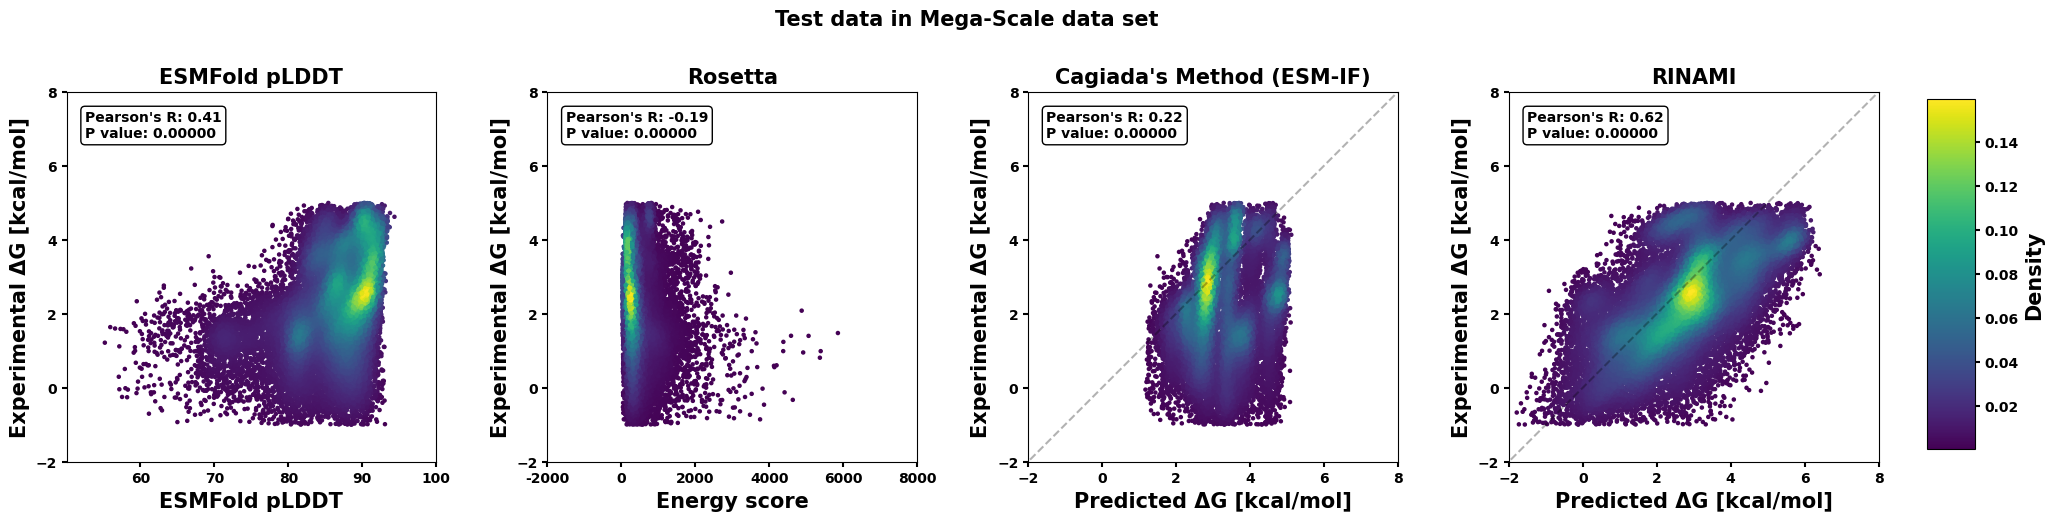

In [6]:

x_lim = (-2, 8)
y_lim = (-2, 8)

# ---- 1つ目のデータ ----
y3 = dG_exp_Mega_test
x3 = list((np.array(plddt_Mega_test)-60)/5)

corr3 = np.corrcoef(x3, y3)[0,1]
sp_corr3, pvalue = spearmanr(x3, y3)
rmse3 = float(np.sqrt(mean_squared_error(x3, y3)))
xy3 = np.vstack([x3, y3])
z3 = gaussian_kde(xy3)(xy3)
stat3, p_value3 = wilcoxon(
    x3,
    y3,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)


# ---- 1つ目のデータ ----
y0 = df_test['dG_ML'].values
x0 = []
natural_npy_dir = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/rosetta_respective_score_data/'
for name in df_test['name'].values:
    npy_file = natural_npy_dir + name + '.npy'
    scores = np.load(npy_file)
    fa_sum_score = np.concatenate([scores[:,0:5], scores[:,6:7], scores[:,10:13]], axis=1)
    sum_scores = np.sum(scores, axis=(0, 1)) 
    x0.append(sum_scores)

corr0 = np.corrcoef(x0, y0)[0,1]
sp_corr0, pvalue = spearmanr(x0, y0)
rmse0 = float(np.sqrt(mean_squared_error(x0, y0)))
xy0 = np.vstack([x0, y0])
z0 = gaussian_kde(xy0)(xy0)
x0 = list(  np.array(x0)/1000  )
# Wilcoxon符号付順位検定（p値のみ）
stat0, p_value0 = wilcoxon(
    x0,
    y0,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)



# ---- 1つ目のデータ ----
y1 = df_test['dG_ML'].values
x1 = []
for name in df_test['name'].values:
    name = name.replace('.pdb', '')
    x1.append(pred_dG_data[name])

corr1 = np.corrcoef(x1, y1)[0,1]
sp_corr1, pvalue = spearmanr(x1, y1)
rmse1 = float(np.sqrt(mean_squared_error(x1, y1)))
xy1 = np.vstack([x1, y1])
z1 = gaussian_kde(xy1)(xy1)
stat1, p_value1 = wilcoxon(
    x1,
    y1,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)



# ---- 2つ目のデータ ----
pdGs, edGs = [], []
with open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/test_result.txt') as f:
    for line in f:
        pdG, edG = map(float, line.strip().split())
        pdGs.append(pdG)
        edGs.append(edG)

x2, y2 = pdGs, edGs
corr2 = np.corrcoef(x2, y2)[0,1]
sp_corr2, pvalue = spearmanr(x2, y2)
rmse2 = float(np.sqrt(mean_squared_error(x2, y2)))
rmse2_Mega = float(np.sqrt(mean_squared_error(x2, y2)))
xy2 = np.vstack([x2, y2])
z2 = gaussian_kde(xy2)(xy2)
stat2, p_value2 = wilcoxon(
    x2,
    y2,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)


# ---- プロットを統合 ----
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for fig_ind, (ax, x, y, z, corr, pvalue, rmse, title) in enumerate(zip(axes, [x3, x0, x1, x2], [y3, y0, y1, y2], [z3, z0, z1, z2], [corr3, corr0, corr1, corr2], [p_value3, p_value0, p_value1, p_value2], [rmse3, rmse0, rmse1, rmse2], ['ESMFold pLDDT', 'Rosetta', 'Cagiada\'s Method (ESM-IF)', model_name])):
    sc = ax.scatter(x, y, c=z, s=5, alpha=1)
    ax.set_title(f'{title}', fontsize=15, fontweight='bold')
    if fig_ind not in [0, 1]:
        ax.plot([x_lim[0]-1,x_lim[1]+1], [y_lim[0]-1,y_lim[1]+1], color='k', alpha=0.3, linestyle='--')
    
    if fig_ind == 0:
        ax.set_xlabel('ESMFold pLDDT', fontsize=15, fontweight='bold')
        ax.set_xticks([0, 2 , 4, 6, 8, 10])
        ax.set_xticklabels(['60', '70', '80', '90', '100', '110'])
    elif fig_ind == 1:
        ax.set_xlabel('Energy score', fontsize=15, fontweight='bold')
        ax.set_xticks([-2, 0, 2, 4, 6, 8])
        ax.set_xticklabels(['-2000', '0', '2000', '4000', '6000', '8000'])
    else:
        ax.set_xlabel('Predicted ΔG [kcal/mol]', fontsize=15, fontweight='bold')
    ax.set_ylabel('Experimental ΔG [kcal/mol]', fontsize=15, fontweight='bold')
    ax.set_xlim(x_lim[0],x_lim[1])
    ax.set_ylim(y_lim[0],y_lim[1])
    ax.set_aspect('equal', adjustable='box')

    # 目盛り設定
    ax.tick_params(axis='both', labelsize=10, width=1.5)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    # 相関係数をプロット内に表示
    ax.text(
        0.05, 0.95,
        f'Pearson\'s R: {corr:.2f}\nP value: {pvalue:.5f}',
        transform=ax.transAxes,
        fontsize=10, fontweight='bold',
        va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

# カラーバー
fig.subplots_adjust(right=0.88, wspace=0.3)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Density', fontsize=15, fontweight='bold')
cbar.ax.tick_params(labelsize=10, width=1.5)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')

plt.suptitle('Test data in Mega-Scale data set', fontsize=15, fontweight='bold', y=1.03)

plt.savefig('../Figures/Scatter_Comparison_on_Mega_test_data.png', dpi=300, bbox_inches='tight')
plt.show()


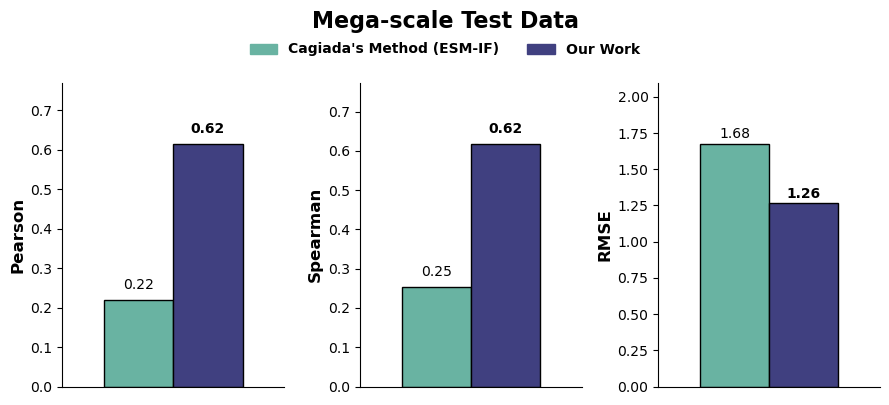

In [111]:
# --- 評価指標と値 ---
metrics = ['Pearson', 'Spearman', 'RMSE']
method1 = [corr1, sp_corr1, rmse1]
method2 = [corr2, sp_corr2, rmse2]
methods = ["Cagiada's Method (ESM-IF)", "Our Work"]
colors = ['#69b3a2', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(9, 4))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m1, m2) in enumerate(zip(axes, metrics, method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 0.5  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    bars1 = ax.bar(x - offset/2, [m1], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[1], label=methods[1], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(0, max(m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 1:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(2)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data', fontsize=16, fontweight='bold', y=1.)

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

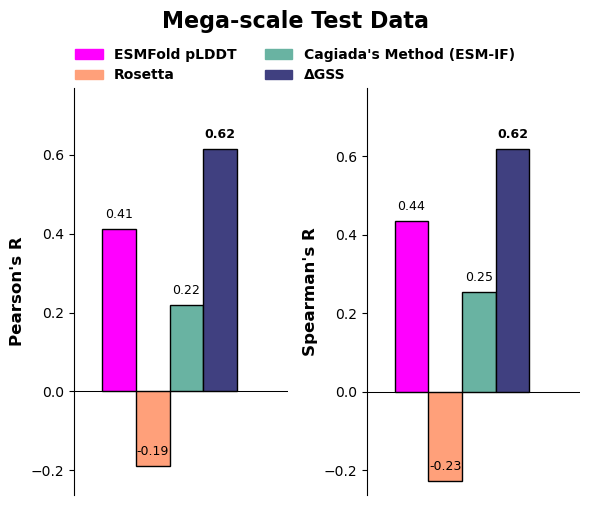

In [112]:
# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R',]
method3 = [corr3, sp_corr3, ]
method0 = [corr0, sp_corr0, ]
method1 = [corr1, sp_corr1, ]
method2 = [corr2, sp_corr2, ]
methods = ["ESMFold pLDDT", "Rosetta", "Cagiada's Method (ESM-IF)", model_name]
colors = ['magenta', 'lightsalmon', '#69b3a2', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(6, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m3, m0, m1, m2) in enumerate(zip(axes, metrics, method3, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = .6  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.3

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars3 = ax.bar(x - offset, [m3], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[2], label=methods[2], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[3], label=methods[3], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-0.25*1.05, max(m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars3, bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 3:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(4)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_on_Mega_test_data.png', dpi=300, bbox_inches='tight')

plt.show()

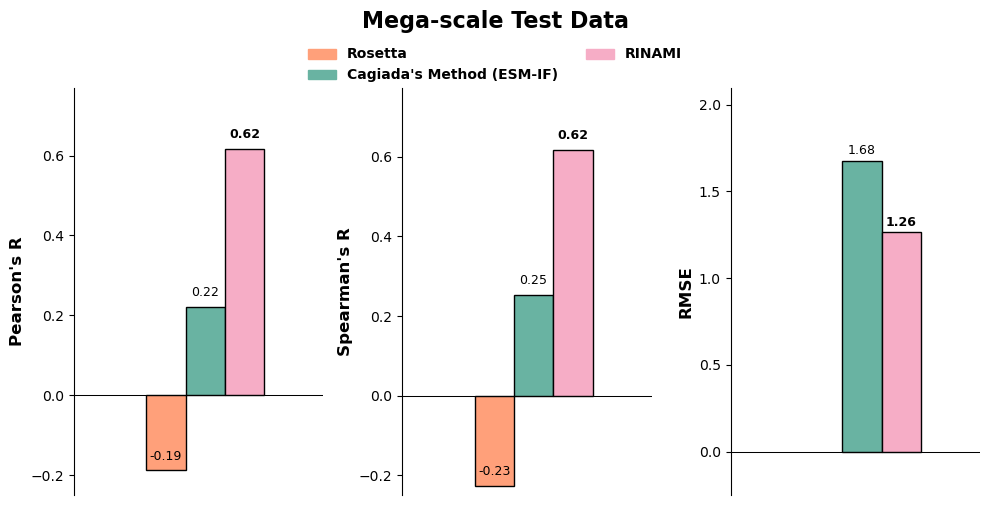

In [7]:
# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R','RMSE']
method0 = [corr0, sp_corr0, 0]
method1 = [corr1, sp_corr1, rmse1]
method2 = [corr2, sp_corr2, rmse2]
methods = ["Rosetta", "Cagiada's Method (ESM-IF)", model_name]
colors = ['lightsalmon', '#69b3a2', '#f6adc6']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m1, m2) in enumerate(zip(axes, metrics, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = .6  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.3

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if metric != 'RMSE':
        bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[2], label=methods[2], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-0.25, max(m0, m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif bar_ind == 0 and metric == 'RMSE':
                continue
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(3)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_on_Mega_test_data.png', dpi=300, bbox_inches='tight')

plt.show()

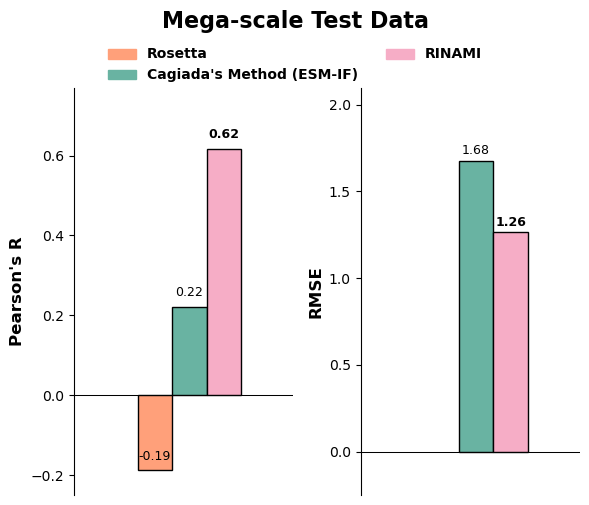

In [8]:
# --- 評価指標と値 ---
metrics = ['Pearson\'s R','RMSE']
method0 = [corr0, 0]
method1 = [corr1, rmse1]
method2 = [corr2, rmse2]
methods = ["Rosetta", "Cagiada's Method (ESM-IF)", model_name]
colors = ['lightsalmon', '#69b3a2', '#f6adc6']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(6, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m1, m2) in enumerate(zip(axes, metrics, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = .6  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.3

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if metric != 'RMSE':
        bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[2], label=methods[2], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-0.25, max(m0, m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif bar_ind == 0 and metric == 'RMSE':
                continue
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(3)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_on_Mega_test_data.png', dpi=300, bbox_inches='tight')

plt.show()

28it [00:00, 126.77it/s]
28it [00:00, 2427.66it/s]


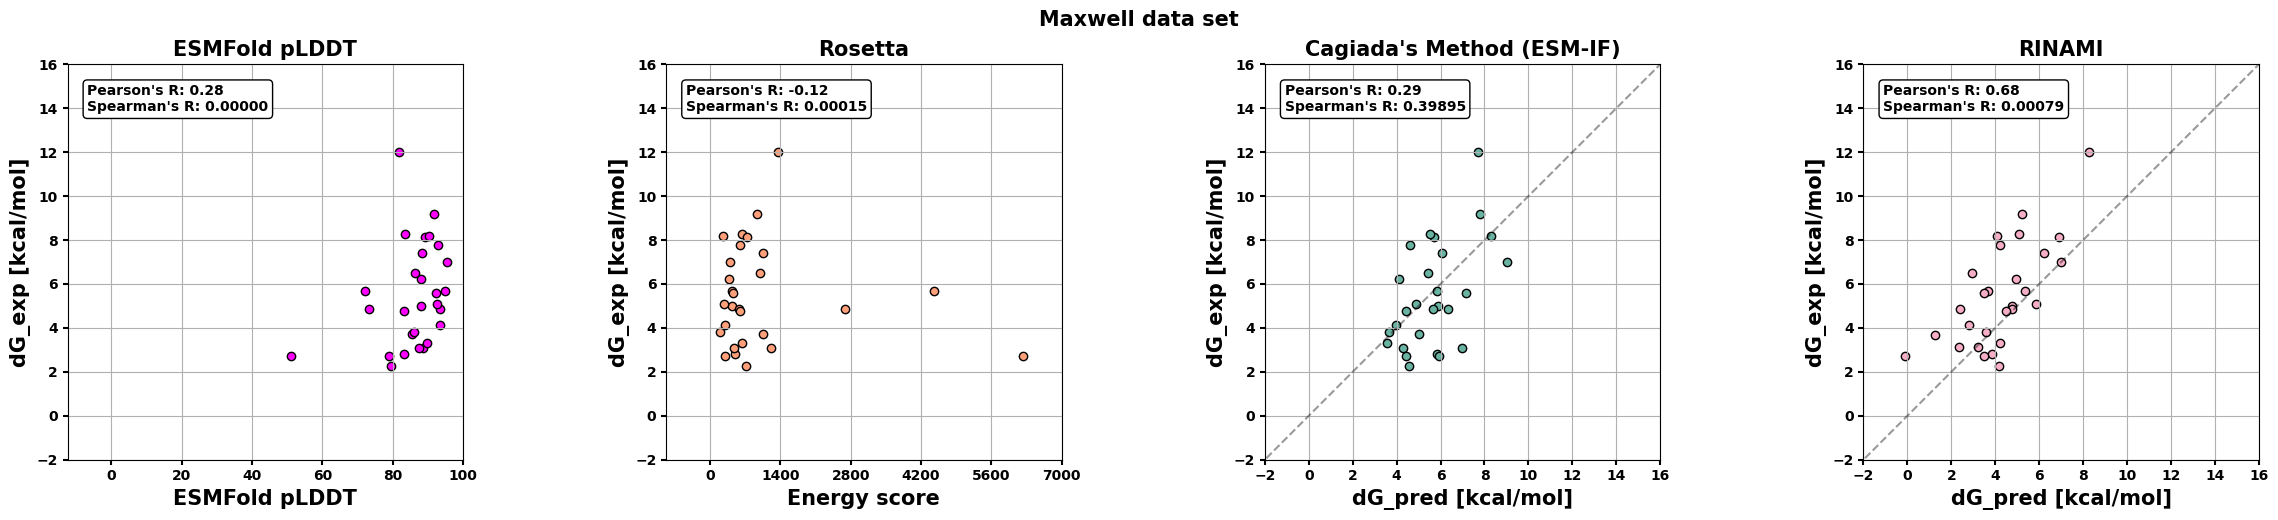

In [9]:
colors = ['magenta', 'lightsalmon', '#69b3a2', '#f6adc6']

x3 = []
y3 = []

for (name, dg) in tqdm.tqdm(zip(df_maxwell['id'], df_maxwell['dg'])):
    pdb_file = glob.glob('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/Maxwell_ESMFold_pdb/' + name + '.pdb')[0]
    plddt = get_pLDDT(pdb_file)
    x3.append(plddt)
    y3.append(dg*0.239006)
x3 = list(np.array(x3)/6.25)
corr3 = np.corrcoef(x3, y3)[0,1]
sp_corr3, pvalue = spearmanr(x3, y3)
rmse3 = float(np.sqrt(mean_squared_error(x3, y3)))
stat3, p_value3 = wilcoxon(
    x3,
    y3,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)

# -------- 0つ目のデータ --------
x0 = []
y0 = []

natural_npy_dir = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/maxwell_rosetta_respective_score_data/'
natural_entire_score = []
for (name, dg) in tqdm.tqdm(zip(df_maxwell['id'], df_maxwell['dg'])):
    npy_file = glob.glob(natural_npy_dir + name + '*.npy')[0]
    scores = np.load(npy_file)
    sum_scores = np.sum(scores, axis=(0, 1)) 
    x0.append(sum_scores)
    y0.append(dg*0.239006)

corr0 = np.corrcoef(x0, y0)[0,1]
sp_corr0, pvalue = spearmanr(x0, y0)
rmse0 = float(np.sqrt(mean_squared_error(x0, y0)))
x0 = list( ( 100*np.array(x0)/7000 )/6.25 )
stat0, p_value0 = wilcoxon(
    x0,
    y0,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)


# -------- 1つ目のデータ --------
x1 = []
y1 = []

# Maxwell and Koga design set
for name in pred_dG_data_maxwell_kogadesign:
    for protein_id in id_to_dg_maxwell:
        if protein_id in name:
            e_dg = id_to_dg_maxwell[protein_id]
            for data_id in pred_dG_data_maxwell_kogadesign:
                if protein_id in data_id:
                    p_dg = pred_dG_data_maxwell_kogadesign[data_id]
                    x1.append(p_dg)   # predicted
                    y1.append(e_dg)   # experimental

corr1 = np.corrcoef(x1, y1)[0,1]
sp_corr1, pvalue = spearmanr(x1, y1)
rmse1 = float(np.sqrt(mean_squared_error(x1, y1)))
stat1, p_value1 = wilcoxon(
    x1,
    y1,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)

# -------- 2つ目のデータ --------
pdGs, edGs = [], []
with open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/maxwell_test_temp.txt') as f:
    for line in f:
        pdG, edG = map(float, line.strip().split())
        pdGs.append(pdG)  # predicted
        edGs.append(edG)  # experimental

x2, y2 = pdGs, edGs   # 実験値, 予測値
corr2 = np.corrcoef(x2, y2)[0,1]
sp_corr2, pvalue = spearmanr(x2, y2)
rmse2 = float(np.sqrt(mean_squared_error(x2, y2)))
rmse2_Maxwell = float(np.sqrt(mean_squared_error(x2, y2)))
stat2, p_value2 = wilcoxon(
    x2,
    y2,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)


# -------- 統合プロット --------
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for fig_ind, (ax, x, y, corr, pvalue, rmse, title, color) in enumerate(zip(
    axes, [x3, x0, x1, x2], [y3, y0, y1, y2], [corr3, corr0, corr1, corr2], [p_value3, p_value0, p_value1, p_value2], [rmse3, rmse0, rmse1, rmse2], ['ESMFold pLDDT', 'Rosetta', 'Cagiada\'s Method (ESM-IF)', model_name], colors
)):
    ax.set_title(f'{title}', fontsize=15, fontweight='bold')
    if fig_ind not in [0,1]:
        ax.plot([-3,17], [-3,17], color='k', alpha=0.4, linestyle='--')
    ax.scatter(x, y, color=color, alpha=1, edgecolor='k')
    ax.set_xlim([-2, 16])
    ax.set_ylim([-2, 16])
    if fig_ind == 0:
        ax.set_xlabel('ESMFold pLDDT', fontsize=15, fontweight='bold')
        ax.set_xticks([ 0, 3.2, 6.4, 9.6, 12.8, 16])
        ax.set_xticklabels([ '0', '20', '40', '60', '80', '100'])
    elif fig_ind == 1:
        ax.set_xlabel('Energy score', fontsize=15, fontweight='bold')
        ax.set_xticks([ 0, 3.2, 6.4, 9.6, 12.8, 16])
        ax.set_xticklabels([ '0', '1400', '2800', '4200', '5600', '7000'], fontsize=8)
    else:
        ax.set_xlabel("dG_pred [kcal/mol]", fontsize=15, fontweight='bold')
    ax.set_ylabel("dG_exp [kcal/mol]", fontsize=15, fontweight='bold')
    ax.grid()
    ax.set_aspect('equal')

    # フォント調整
    ax.tick_params(axis='both', labelsize=10, width=1.5)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    # 相関係数を白背景ボックス付きで表示
    ax.text(
        0.05, 0.95,
        f'Pearson\'s R: {corr:.2f}\nSpearman\'s R: {pvalue:.5f}',
        transform=ax.transAxes,
        fontsize=10, fontweight='bold',
        va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.tight_layout()

plt.suptitle('Maxwell data set', fontsize=15, fontweight='bold', y=1.03)
plt.savefig('../Figures/Scatter_Comparison_on_Maxwell_data.png', dpi=300, bbox_inches='tight')

plt.show()


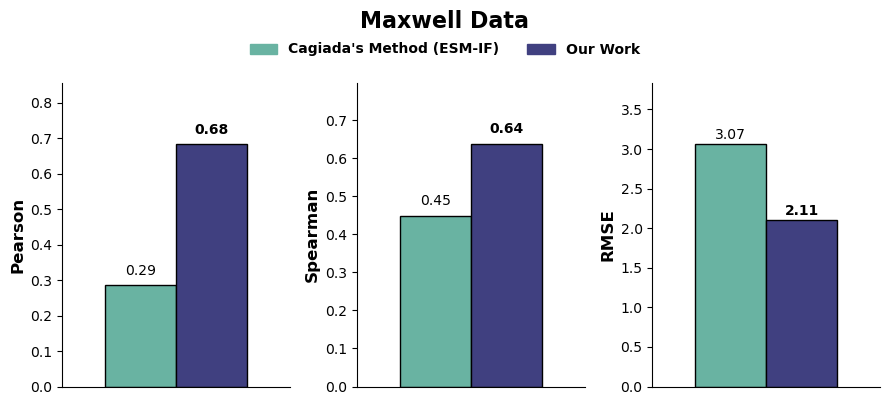

In [10]:
# --- 評価指標と値 ---
metrics = ['Pearson', 'Spearman', 'RMSE']
method1 = [corr1, sp_corr1, rmse1]
method2 = [corr2, sp_corr2, rmse2]
methods = ["Cagiada's Method (ESM-IF)", "Our Work"]
colors = ['#69b3a2', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(9, 4))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m1, m2) in enumerate(zip(axes, metrics, method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 0.5  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    bars1 = ax.bar(x - offset/2, [m1], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[1], label=methods[1], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(0, max(m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 1:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(2)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data', fontsize=16, fontweight='bold', y=1.)

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

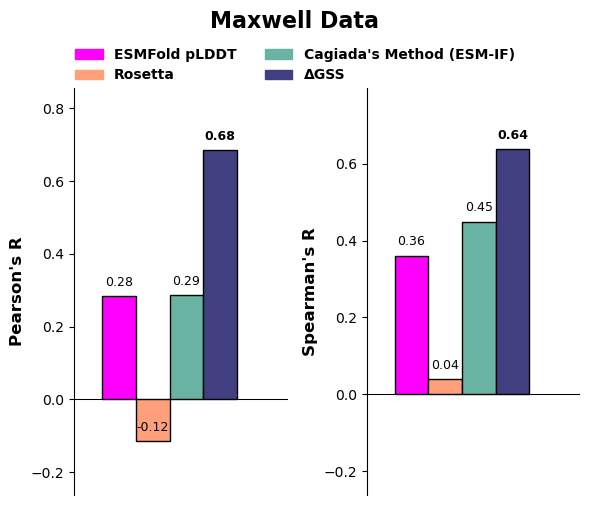

In [11]:
# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R',]
method3 = [corr3, sp_corr3, ]
method0 = [corr0, sp_corr0, ]
method1 = [corr1, sp_corr1, ]
method2 = [corr2, sp_corr2, ]
methods = ["ESMFold pLDDT", "Rosetta", "Cagiada's Method (ESM-IF)", model_name]
colors = ['magenta', 'lightsalmon', '#69b3a2', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(6, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m3, m0, m1, m2) in enumerate(zip(axes, metrics, method3, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = .6  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.3

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars3 = ax.bar(x - offset, [m3], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[2], label=methods[2], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[3], label=methods[3], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-0.25*1.05, max(m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars3, bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 3:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(4)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data', fontsize=16, fontweight='bold', y=1.)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_on_Maxwell_data.png', dpi=300, bbox_inches='tight')

plt.show()

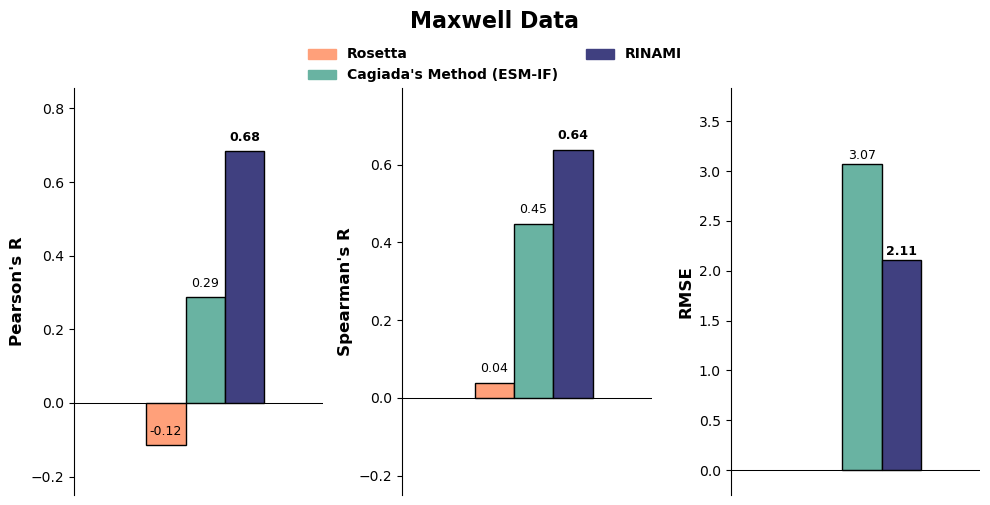

In [10]:
# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R','RMSE']
method0 = [corr0, sp_corr0, 0]
method1 = [corr1, sp_corr1, rmse1]
method2 = [corr2, sp_corr2, rmse2]
methods = ["Rosetta", "Cagiada's Method (ESM-IF)", model_name]
colors = ['lightsalmon', '#69b3a2', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m1, m2) in enumerate(zip(axes, metrics, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = .6  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.3

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if metric != 'RMSE':
        bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[2], label=methods[2], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-0.25, max(m0, m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif bar_ind == 0 and metric == 'RMSE':
                continue
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(3)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_on_Maxwell_data.png', dpi=300, bbox_inches='tight')

plt.show()

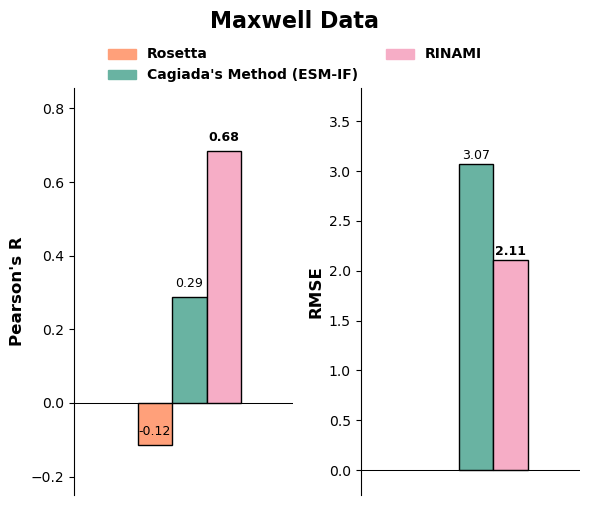

In [12]:
# --- 評価指標と値 ---
metrics = ['Pearson\'s R','RMSE']
method0 = [corr0, 0]
method1 = [corr1, rmse1]
method2 = [corr2, rmse2]
methods = ["Rosetta", "Cagiada's Method (ESM-IF)", model_name]
colors = ['lightsalmon', '#69b3a2', '#f6adc6']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(6, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m1, m2) in enumerate(zip(axes, metrics, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = .6  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.3

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if metric != 'RMSE':
        bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[2], label=methods[2], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-0.25, max(m0, m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif bar_ind == 0 and metric == 'RMSE':
                continue
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(3)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_on_Maxwell_data.png', dpi=300, bbox_inches='tight')

plt.show()

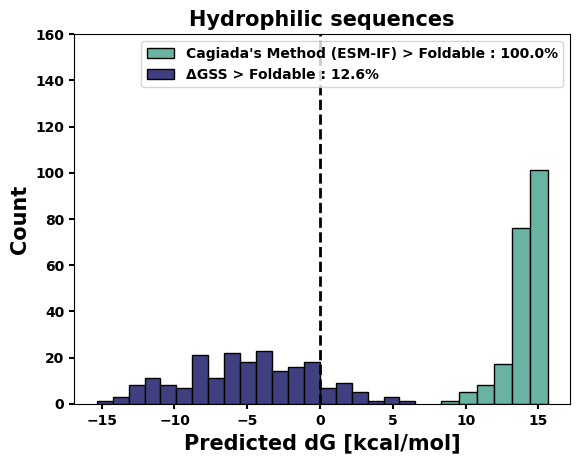

In [116]:
# -------- 1つ目のデータ --------
ESM_IF_data = json.load(open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/likelihood_data/Hydrophilic_sequence_test.json'))
dG_preds_ESM_IF = []
foldable_count_ESM_IF = 0
not_foldable_count_ESM_IF = 0
for name in ESM_IF_data:
    dG_pred = ESM_IF_data[name]
    if dG_pred > 0:
        foldable_count_ESM_IF += 1
    else:
        not_foldable_count_ESM_IF += 1
    dG_preds_ESM_IF.append(dG_pred)
# -------- 2つ目のデータ --------
hydrophilic_test_f = open('/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/Hydrophilic_test_result.txt')
dG_preds_this_work = []
foldable_count_this_work = 0
not_foldable_count_this_work = 0
for line in hydrophilic_test_f:
    dG_pred = float(line.split('=')[-1])
    dG_preds_this_work.append(dG_pred)
    if dG_pred > 0:
        foldable_count_this_work += 1
    else:
        not_foldable_count_this_work += 1

colors = [ '#69b3a2', '#404080']

fig, ax = plt.subplots()
plt.hist(dG_preds_ESM_IF, bins=6, color=colors[0], alpha=1, edgecolor='black')
plt.hist(dG_preds_this_work, bins=20, color=colors[1], alpha=1, edgecolor='black')
plt.ylim(0, 160)
plt.xlabel('Predicted dG [kcal/mol]', fontsize=15, fontweight='bold')
plt.ylabel('Count', fontsize=15, fontweight='bold')
plt.title('Hydrophilic sequences', fontsize=15, fontweight='bold')
plt.legend([f'Cagiada\'s Method (ESM-IF) > Foldable : {round(100*foldable_count_ESM_IF/(foldable_count_ESM_IF+not_foldable_count_ESM_IF),1)}%', f'{model_name} > Foldable : {round(100*foldable_count_this_work/(foldable_count_this_work+not_foldable_count_this_work), 1)}%'], fontsize=10,prop={'weight':'bold'}) 
plt.plot([0,0], [0,170], color='k', linestyle='--', linewidth=2)

'''
ax.text(
    0.05, 0.95,
    f'Foldable: {foldable_count_this_work}/{foldable_count_this_work+not_foldable_count_this_work}\nNot Foldable: {not_foldable_count_this_work}/{foldable_count_this_work+not_foldable_count_this_work}',
    transform=ax.transAxes,
    fontsize=10, fontweight='bold',
    va='top', ha='left',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
'''

# フォント調整
ax.tick_params(axis='both', labelsize=10, width=1.5)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.savefig('../Figures/Histgram_Comparison_on_Hydrophilic.png', dpi=300, bbox_inches='tight')


構築したモデルとは独立の手法で（IDP予測で）この予測のおかしさを示す

IDP予測を掻い潜る配列がこの図のfoldableな25%と対応しているのか？

👇

metapredictで予測したところ、いずれもIDP判定

In [79]:
sb.call(f'mkdir -p ../processed_data/wt_dG_mat/Figures', shell=True)
c_map = 'bwr'

# 並べ替えたいアミノ酸の順番をここで指定
# 例: 脂溶性から親水性にしたり、アルファベット順など
desired_order = list("QENHDRKTSAGMCLVIWYFP")

master_pdf_path = '../processed_data/wt_dG_mat/Figures/wt_dG_mat_ALL_in_one.pdf'
with PdfPages(master_pdf_path) as pdf:
    for npy_file in glob.glob('../processed_data/wt_dG_mat/*.npy'):
        pdb_file = npy_file.replace('_res_wise_dG.npy', '.pdb').replace('wt_dG_mat', 'Mega_mt_pdb')
        seq = get_sequence_from_single_chain_pdb(pdb_file)
        npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG.npy', '')

        pdb_file = npy_file.replace('_res_wise_dG.npy', '.pdb').replace('wt_dG_mat', 'Mega_mt_pdb')
        seq = get_sequence_from_single_chain_pdb(pdb_file)
        
        rASA_list = compute_rasa(pdb_file)

        x_tick_colors = []
        for rASA in rASA_list.values():
            if rASA <= 0.16:
                x_tick_colors.append('black')
            elif rASA > 0.16:
                x_tick_colors.append('gray')

        MPNN_profile = np.load(npy_file.replace('_res_wise_dG.npy', '_profile.npy').replace('wt_dG_mat', 'Mega_mt_profile_data'))
        dG_mat = np.load(npy_file).T

        corr1 = np.corrcoef(np.ravel(dG_mat), np.ravel(MPNN_profile))[0,1]
        sp_corr1, pvalue = spearmanr(np.ravel(dG_mat), np.ravel(MPNN_profile))
        
        n_aa, len_seq = dG_mat.shape
        xtick_list = [f'{ind}{aa}' for ind, aa in zip(np.arange(1, len_seq + 1), seq)]
        # 現在のアミノ酸順（ファイルの行の並びがこの順に対応している想定）
        aa_list = list("ACDEFGHIKLMNPQRSTVWY")

        # ✅ 並べ替えインデックスを求める
        reorder_index = [aa_list.index(aa) for aa in desired_order if aa in aa_list]

        # ✅ 行列とラベルを並べ替える
        dG_mat = dG_mat[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]
        # ✅ 行列とラベルを並べ替える
        MPNN_profile = MPNN_profile[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]

        # ====== Figureを統合して作成（散布図の高さを小さく、中心は揃える） ======
        fig = plt.figure(figsize=(20, 6))

        # 横方向3分割（散布図は幅を小さめに）
        gs = fig.add_gridspec(
            1, 3,
            width_ratios=[1.2, 1.2, 0.7],  # ← 散布図だけ細く
            wspace=0.4
        )

        # 左2つは普通に1セルずつ
        ax0 = fig.add_subplot(gs[0, 0])   # dG matrix
        ax1 = fig.add_subplot(gs[0, 1])   # MPNN profile

        # 右カラム（散布図）はさらに縦3分割を作り、中央の小さい枠にだけプロット
        # shrink を小さくすると散布図の高さが縮む（上下の余白が等分 → 中心位置が揃う）
        shrink = 0.55  # 例: 散布図の高さをこの割合に（0.4〜0.7くらいで調整）
        top_bot = (1.0 - shrink) / 2.0
        gs_right = gridspec.GridSpecFromSubplotSpec(
            3, 1, subplot_spec=gs[0, 2],
            height_ratios=[top_bot, shrink, top_bot],  # 上・中央（散布図）・下
            hspace=0.0
        )
        ax2 = fig.add_subplot(gs_right[1, 0])  # 中央だけ使う（これで上下対称の余白）

        # ---------- (1) dG行列 ----------
        im0 = ax0.imshow(dG_mat, cmap=c_map, vmin=-1.5, vmax=1.5)
        max_idx_dG = np.argmax(dG_mat, axis=0)
        #ax0.scatter(np.arange(len_seq), max_idx_dG, color='black', s=6, marker='o',linewidths=0.5, edgecolors='white', zorder=3)
        ax0.set_yticks(np.arange(len(aa_list_reordered)))
        ax0.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax0.set_xticks(np.arange(len_seq))
        ax0.set_xticks(np.arange(len_seq))
        ax0.set_xticklabels(xtick_list, fontsize=6, fontweight='bold', rotation=90)
        for label, color in zip(ax0.get_xticklabels(), x_tick_colors):
            label.set_color(color)
        ax0.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax0.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax0.set_title('Residue-AA-wise dG Matrix', fontsize=13, fontweight='bold')

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider0 = make_axes_locatable(ax0)
        cax0 = divider0.append_axes("right", size="5%", pad=0.05)
        cbar0 = plt.colorbar(im0, cax=cax0)
        cbar0.set_label('ΔG [kcal/mol]', fontsize=12, fontweight='bold')

        # ---------- (2) MPNNプロファイル ----------
        im1 = ax1.imshow(MPNN_profile, cmap=c_map, vmin=0, vmax=1)
        max_idx_prof = np.argmax(MPNN_profile, axis=0)
        ax1.scatter(np.arange(len_seq), max_idx_prof, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax1.set_yticks(np.arange(len(aa_list_reordered)))
        ax1.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax1.set_xticks(np.arange(len_seq))
        ax1.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax1.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax1.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax1.set_title('ProteinMPNN profile', fontsize=13, fontweight='bold')

        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        cbar1 = plt.colorbar(im1, cax=cax1)
        cbar1.set_label('Probability', fontsize=12, fontweight='bold')

        # ---------- (3) 散布図（高さを shrink で縮め、中心は左右と揃う） ----------
        ax2.scatter(np.ravel(dG_mat), np.ravel(MPNN_profile),
                    color='gray', edgecolor='k', alpha=0.7, s=5)
        ax2.set_xlabel('Residue wise dG [kcal/mol]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Residue wise dG vs MPNN profile', fontsize=13, fontweight='bold')
        ax2.text(0.05, 0.95, f'Pearson: {corr1:.2f}\nSpearman: {sp_corr1:.2f}',
                transform=ax2.transAxes, va='top', ha='left',
                fontsize=10, fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))

        # 図全体タイトルと保存
        fig.suptitle(f'{npy_file_label}: dG / Profile / Correlation', fontsize=15, fontweight='bold', y=.8)
        out_path = f'../processed_data/wt_dG_mat/Figures/{npy_file_label}_combined.pdf'
        fig.savefig(out_path, dpi=300, bbox_inches='tight')
        pdf.savefig(fig, dpi=300, bbox_inches='tight')
        plt.close(fig)

In [159]:
sb.call(f'mkdir -p ../processed_data/Hydrophilic_dG_mat/Figures', shell=True)

w = open('../processed_data/fasta/Hydrophilic_sequences.fasta', 'w')

c_map = 'bwr'

# 並べ替えたいアミノ酸の順番をここで指定
# 例: 脂溶性から親水性にしたり、アルファベット順など
desired_order = list("QENHDRKTSAGMCLVIWYFP")

master_pdf_path = '../processed_data/Hydrophilic_dG_mat/Figures/Hydrophilic_dG_mat_ALL_in_one.pdf'
with PdfPages(master_pdf_path) as pdf:
    for npy_file in glob.glob('../processed_data/Hydrophilic_dG_mat/*.npy'):
        try:
            seq_unit = npy_file.split('/')[-1].split('_')[0]
            pdb_file = glob.glob(npy_file.replace('_res_wise_dG.npy', '*.pdb').replace('Hydrophilic_dG_mat', 'T_rich_original_for_methyl_deletion'))[0]
            seq = get_sequence_from_single_chain_pdb(pdb_file)
            npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG.npy', '')
            w.write(f'>{npy_file_label}\n{seq}\n')

                


            MPNN_profile = np.load(glob.glob(npy_file.replace('_res_wise_dG.npy', '*_profile.npy').replace('Hydrophilic_dG_mat', 'T_rich_original_for_methyl_deletion_profile_data'))[0])
            dG_mat = np.load(npy_file).T

            corr1 = np.corrcoef(np.ravel(dG_mat), np.ravel(MPNN_profile))[0,1]
            sp_corr1, pvalue = spearmanr(np.ravel(dG_mat), np.ravel(MPNN_profile))
            
            n_aa, len_seq = dG_mat.shape
            xtick_list = [f'{ind}{aa}' for ind, aa in zip(np.arange(1, len_seq + 1), seq)]
            # 現在のアミノ酸順（ファイルの行の並びがこの順に対応している想定）
            aa_list = list("ACDEFGHIKLMNPQRSTVWY")

            # ✅ 並べ替えインデックスを求める
            reorder_index = [aa_list.index(aa) for aa in desired_order if aa in aa_list]

            # ✅ 行列とラベルを並べ替える
            dG_mat = dG_mat[reorder_index, :]
            aa_list_reordered = [aa_list[i] for i in reorder_index]
            # ✅ 行列とラベルを並べ替える
            MPNN_profile = MPNN_profile[reorder_index, :]
            aa_list_reordered = [aa_list[i] for i in reorder_index]

            # ====== Figureを統合して作成（散布図の高さを小さく、中心は揃える） ======
            fig = plt.figure(figsize=(50, 30))

            # 横方向3分割（散布図は幅を小さめに）
            gs = fig.add_gridspec(
                1, 3,
                width_ratios=[1.2, 1.2, 0.7],  # ← 散布図だけ細く
                wspace=0.15
            )

            # 左2つは普通に1セルずつ
            ax0 = fig.add_subplot(gs[0, 0])   # dG matrix
            ax1 = fig.add_subplot(gs[0, 1])   # MPNN profile

            # 右カラム（散布図）はさらに縦3分割を作り、中央の小さい枠にだけプロット
            # shrink を小さくすると散布図の高さが縮む（上下の余白が等分 → 中心位置が揃う）
            shrink = 0.3  # 例: 散布図の高さをこの割合に（0.4〜0.7くらいで調整）
            top_bot = (1.0 - shrink) / 2.0
            gs_right = gridspec.GridSpecFromSubplotSpec(
                3, 1, subplot_spec=gs[0, 2],
                height_ratios=[top_bot, shrink, top_bot],  # 上・中央（散布図）・下
                hspace=0.0
            )
            ax2 = fig.add_subplot(gs_right[1, 0])  # 中央だけ使う（これで上下対称の余白）

            # ---------- (1) dG行列 ----------
            im0 = ax0.imshow(dG_mat, cmap=c_map, vmin=-1.5, vmax=1.5)
            max_idx_dG = np.argmax(dG_mat, axis=0)
            ax0.scatter(np.arange(len_seq), max_idx_dG, color='black', s=6, marker='o',
                        linewidths=0.5, edgecolors='white', zorder=3)
            ax0.set_yticks(np.arange(len(aa_list_reordered)))
            ax0.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
            ax0.set_xticks(np.arange(len_seq))
            ax0.set_xticklabels(xtick_list, fontsize=6, fontweight='bold', rotation=90)
            ax0.set_xlabel("Residue position", fontsize=12, fontweight='bold')
            ax0.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
            ax0.set_title('Residue・AA-wise dG Matrix', fontsize=13, fontweight='bold')

            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider0 = make_axes_locatable(ax0)
            cax0 = divider0.append_axes("right", size="5%", pad=0.05)
            cbar0 = plt.colorbar(im0, cax=cax0)
            cbar0.set_label('dG [kcal/mol]', fontsize=12, fontweight='bold')

            # ---------- (2) MPNNプロファイル ----------
            im1 = ax1.imshow(MPNN_profile, cmap=c_map, vmin=0, vmax=1)
            max_idx_prof = np.argmax(MPNN_profile, axis=0)
            ax1.scatter(np.arange(len_seq), max_idx_prof, color='black', s=6, marker='o',
                        linewidths=0.5, edgecolors='white', zorder=3)
            ax1.set_yticks(np.arange(len(aa_list_reordered)))
            ax1.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
            ax1.set_xticks(np.arange(len_seq))
            ax1.set_xticklabels(xtick_list, fontsize=6, fontweight='bold', rotation=90)
            ax1.set_xlabel("Residue position", fontsize=12, fontweight='bold')
            ax1.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
            ax1.set_title('ProteinMPNN profile', fontsize=13, fontweight='bold')

            divider1 = make_axes_locatable(ax1)
            cax1 = divider1.append_axes("right", size="5%", pad=0.05)
            cbar1 = plt.colorbar(im1, cax=cax1)
            cbar1.set_label('Probability', fontsize=12, fontweight='bold')

            # ---------- (3) 散布図（高さを shrink で縮め、中心は左右と揃う） ----------
            ax2.scatter(np.ravel(dG_mat), np.ravel(MPNN_profile),
                        color='gray', edgecolor='k', alpha=0.7, s=5)
            ax2.set_xlabel('Residue wise dG [kcal/mol]', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
            ax2.set_title('Residue wise dG vs MPNN profile', fontsize=13, fontweight='bold')
            ax2.text(0.05, 0.95, f'Pearson: {corr1:.2f}\nSpearman: {sp_corr1:.2f}',
                    transform=ax2.transAxes, va='top', ha='left',
                    fontsize=10, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))

            # 図全体タイトルと保存
            fig.suptitle(f'{npy_file_label}: dG / Profile / Correlation', fontsize=15, fontweight='bold', y=.6)
            out_path = f'../processed_data/Hydrophilic_dG_mat/Figures/{npy_file_label}_combined.pdf'
            fig.savefig(out_path, dpi=300, bbox_inches='tight')
            pdf.savefig(fig, dpi=300, bbox_inches='tight')
            plt.close(fig)
            
        except:
            None

/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages

sb.call(f'mkdir -p ../processed_data/Hydrophilic_dG_mat/Figures', shell=True)

# 並べ替えたいアミノ酸の順番をここで指定
# 例: 脂溶性から親水性にしたり、アルファベット順など
desired_order = list("QENHDRKTSAGMCLVIWYFP")

for npy_file in glob.glob('../processed_data/Hydrophilic_dG_mat/*.npy'):
    # データ読み込み
    npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG.npy', '')
    npy = np.load(npy_file).T
    n_aa, len_seq = npy.shape
    print(f"Matrix shape: {n_aa} × {len_seq}")

    # 現在のアミノ酸順（ファイルの行の並びがこの順に対応している想定）
    aa_list = list("ACDEFGHIKLMNPQRSTVWY")

    # ✅ 並べ替えインデックスを求める
    reorder_index = [aa_list.index(aa) for aa in desired_order if aa in aa_list]

    # ✅ 行列とラベルを並べ替える
    npy = npy[reorder_index, :]
    aa_list_reordered = [aa_list[i] for i in reorder_index]

    # プロット
    fig, ax = plt.subplots(figsize=(18, 8))
    im = ax.imshow(npy, cmap='bwr', vmin=-1.5, vmax=1.5)

    # ✅ 各列で最大値を取る行（アミノ酸）を取得
    max_indices = np.argmax(npy, axis=0)  # 各列の最大行インデックス（長さ = len_seq）

    # ✅ 各列の最大点にマーカーをプロット
    ax.scatter(
        np.arange(len_seq),        # x座標（列のインデックス）
        max_indices,               # y座標（行のインデックス）
        color='black',             # マーカー色
        s=10,                      # サイズ
        marker='o',                # 円マーカー
        linewidths=0.5,
        edgecolors='white',        # 白縁で見やすく
        zorder=3                   # imshowの上に表示
    )
    
    # カラーバー（縦幅を合わせる）
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('dG [kcal/mol]', fontsize=12, fontweight='bold')

    # y軸（アミノ酸）
    ax.set_yticks(np.arange(len(aa_list_reordered)))
    ax.set_yticklabels(aa_list_reordered, fontsize=7, fontweight='bold')

    # x軸（残基番号）
    ax.set_xticks(np.arange(len_seq))
    ax.set_xticklabels(np.arange(1, len_seq + 1), fontsize=7, fontweight='bold', rotation=90)

    # 軸ラベル
    ax.set_xlabel("Residue position", fontsize=12, fontweight='bold')
    ax.set_ylabel("Amino acid", fontsize=12, fontweight='bold')

    ax.set_title(f'dG Matrix ({npy_file_label})',
                 fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'../processed_data/Hydrophilic_dG_mat/Figures/{npy_file_label}_dG_matrix_reordered.pdf', dpi=300)
    plt.show()

・天然配列ライクで、何かしらに巻かせる
👇
・AF２で予測をミスった(けどスコアは高い)
・IDP配列を集めてそれをESMか何かで適当なそれっぽい構造に巻かせてみる
・ランダム配列生成 -> Disoder予測ツール -> フィルタリングでIDP判定くらったやつをピックアップしてESMに構造予測させる

・dGが負のデータに対しては構造をWTのそれにすべき？
・親水性配列群をIDP予測にかけたらどちらの判定が返ってくる？

（理想）
・天然タンパク質の配列なんだけど、天然構造ではない構造にフォールドしつつ原子衝突を生じていない構造
・AFDB内をPDBの構造をクエリとして検索し、対応構造同士のTMscoreが低く、アラインメントされた領域のplddtが高いサンプルをデコイデータとしてみなす






ProteinMPNNの出力プロファイルとこれらの行列を比較してみる

この手法で見れるのは単なる安定性であって、他に安定な構造があるのか否かはAF2の予測をしてみないとわからないということ？


(モデル名の案)
・dGSS:dG prediction model with Sequencial and Structural informations

In [498]:
sb.call(f'mkdir -p ../processed_data/wt_dG_mat_poly_Cys/Figures', shell=True)
c_map = 'bwr'

# 並べ替えたいアミノ酸の順番をここで指定
# 例: 脂溶性から親水性にしたり、アルファベット順など
desired_order = list("QENHDRKTSAGMCLVIWYFP")

master_pdf_path = '../processed_data/wt_dG_mat_poly_Cys/Figures/wt_dG_mat_ALL_in_one.pdf'
with PdfPages(master_pdf_path) as pdf:
    for npy_file in glob.glob('../processed_data/wt_dG_mat_poly_Cys/*.npy'):
        pdb_file = npy_file.replace('_res_wise_dG_poly_Cys.npy', '.pdb').replace('wt_dG_mat_poly_Cys', 'Mega_mt_pdb')
        seq = get_sequence_from_single_chain_pdb(pdb_file)
        npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG_poly_Cys.npy', '')

        MPNN_profile = np.load(npy_file.replace('_res_wise_dG_poly_Cys.npy', '_profile.npy').replace('wt_dG_mat_poly_Cys', 'Mega_mt_profile_data'))
        dG_mat = np.load(npy_file).T

        corr1 = np.corrcoef(np.ravel(dG_mat), np.ravel(MPNN_profile))[0,1]
        sp_corr1, pvalue = spearmanr(np.ravel(dG_mat), np.ravel(MPNN_profile))
        
        n_aa, len_seq = dG_mat.shape
        xtick_list = [f'{ind}{aa}' for ind, aa in zip(np.arange(1, len_seq + 1), seq)]
        # 現在のアミノ酸順（ファイルの行の並びがこの順に対応している想定）
        aa_list = list("ACDEFGHIKLMNPQRSTVWY")

        # ✅ 並べ替えインデックスを求める
        reorder_index = [aa_list.index(aa) for aa in desired_order if aa in aa_list]

        # ✅ 行列とラベルを並べ替える
        dG_mat = dG_mat[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]
        # ✅ 行列とラベルを並べ替える
        MPNN_profile = MPNN_profile[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]

        # ====== Figureを統合して作成（散布図の高さを小さく、中心は揃える） ======
        fig = plt.figure(figsize=(20, 6))

        # 横方向3分割（散布図は幅を小さめに）
        gs = fig.add_gridspec(
            1, 3,
            width_ratios=[1.2, 1.2, 0.7],  # ← 散布図だけ細く
            wspace=0.4
        )

        # 左2つは普通に1セルずつ
        ax0 = fig.add_subplot(gs[0, 0])   # dG matrix
        ax1 = fig.add_subplot(gs[0, 1])   # MPNN profile

        # 右カラム（散布図）はさらに縦3分割を作り、中央の小さい枠にだけプロット
        # shrink を小さくすると散布図の高さが縮む（上下の余白が等分 → 中心位置が揃う）
        shrink = 0.55  # 例: 散布図の高さをこの割合に（0.4〜0.7くらいで調整）
        top_bot = (1.0 - shrink) / 2.0
        gs_right = gridspec.GridSpecFromSubplotSpec(
            3, 1, subplot_spec=gs[0, 2],
            height_ratios=[top_bot, shrink, top_bot],  # 上・中央（散布図）・下
            hspace=0.0
        )
        ax2 = fig.add_subplot(gs_right[1, 0])  # 中央だけ使う（これで上下対称の余白）

        # ---------- (1) dG行列 ----------
        im0 = ax0.imshow(dG_mat, cmap=c_map, vmin=-1.5, vmax=1.5)
        max_idx_dG = np.argmax(dG_mat, axis=0)
        ax0.scatter(np.arange(len_seq), max_idx_dG, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax0.set_yticks(np.arange(len(aa_list_reordered)))
        ax0.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax0.set_xticks(np.arange(len_seq))
        ax0.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax0.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax0.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax0.set_title('Residue・AA-wise dG Matrix', fontsize=13, fontweight='bold')

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider0 = make_axes_locatable(ax0)
        cax0 = divider0.append_axes("right", size="5%", pad=0.05)
        cbar0 = plt.colorbar(im0, cax=cax0)
        cbar0.set_label('dG [kcal/mol]', fontsize=12, fontweight='bold')

        # ---------- (2) MPNNプロファイル ----------
        im1 = ax1.imshow(MPNN_profile, cmap=c_map, vmin=0, vmax=1)
        max_idx_prof = np.argmax(MPNN_profile, axis=0)
        ax1.scatter(np.arange(len_seq), max_idx_prof, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax1.set_yticks(np.arange(len(aa_list_reordered)))
        ax1.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax1.set_xticks(np.arange(len_seq))
        ax1.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax1.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax1.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax1.set_title('ProteinMPNN profile', fontsize=13, fontweight='bold')

        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        cbar1 = plt.colorbar(im1, cax=cax1)
        cbar1.set_label('Probability', fontsize=12, fontweight='bold')

        # ---------- (3) 散布図（高さを shrink で縮め、中心は左右と揃う） ----------
        ax2.scatter(np.ravel(dG_mat), np.ravel(MPNN_profile),
                    color='gray', edgecolor='k', alpha=0.7, s=5)
        ax2.set_xlabel('Residue wise dG [kcal/mol]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Residue wise dG vs MPNN profile', fontsize=13, fontweight='bold')
        ax2.text(0.05, 0.95, f'Pearson: {corr1:.2f}\nSpearman: {sp_corr1:.2f}',
                transform=ax2.transAxes, va='top', ha='left',
                fontsize=10, fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))

        # 図全体タイトルと保存
        fig.suptitle(f'{npy_file_label}: dG / Profile / Correlation', fontsize=15, fontweight='bold', y=.8)
        out_path = f'../processed_data/wt_dG_mat_poly_Cys/Figures/{npy_file_label}_combined.pdf'
        fig.savefig(out_path, dpi=300, bbox_inches='tight')
        pdf.savefig(fig, dpi=300, bbox_inches='tight')
        plt.close(fig)

/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages

In [499]:
sb.call(f'mkdir -p ../processed_data/wt_dG_mat_poly_Val/Figures', shell=True)
c_map = 'bwr'

# 並べ替えたいアミノ酸の順番をここで指定
# 例: 脂溶性から親水性にしたり、アルファベット順など
desired_order = list("QENHDRKTSAGMCLVIWYFP")

master_pdf_path = '../processed_data/wt_dG_mat_poly_Val/Figures/wt_dG_mat_ALL_in_one.pdf'
with PdfPages(master_pdf_path) as pdf:
    for npy_file in glob.glob('../processed_data/wt_dG_mat_poly_Val/*.npy'):
        pdb_file = npy_file.replace('_res_wise_dG_poly_Val.npy', '.pdb').replace('wt_dG_mat_poly_Val', 'Mega_mt_pdb')
        seq = get_sequence_from_single_chain_pdb(pdb_file)
        npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG_poly_Val.npy', '')

        MPNN_profile = np.load(npy_file.replace('_res_wise_dG_poly_Val.npy', '_profile.npy').replace('wt_dG_mat_poly_Val', 'Mega_mt_profile_data'))
        dG_mat = np.load(npy_file).T

        corr1 = np.corrcoef(np.ravel(dG_mat), np.ravel(MPNN_profile))[0,1]
        sp_corr1, pvalue = spearmanr(np.ravel(dG_mat), np.ravel(MPNN_profile))
        
        n_aa, len_seq = dG_mat.shape
        xtick_list = [f'{ind}{aa}' for ind, aa in zip(np.arange(1, len_seq + 1), seq)]
        # 現在のアミノ酸順（ファイルの行の並びがこの順に対応している想定）
        aa_list = list("ACDEFGHIKLMNPQRSTVWY")

        # ✅ 並べ替えインデックスを求める
        reorder_index = [aa_list.index(aa) for aa in desired_order if aa in aa_list]

        # ✅ 行列とラベルを並べ替える
        dG_mat = dG_mat[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]
        # ✅ 行列とラベルを並べ替える
        MPNN_profile = MPNN_profile[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]

        # ====== Figureを統合して作成（散布図の高さを小さく、中心は揃える） ======
        fig = plt.figure(figsize=(20, 6))

        # 横方向3分割（散布図は幅を小さめに）
        gs = fig.add_gridspec(
            1, 3,
            width_ratios=[1.2, 1.2, 0.7],  # ← 散布図だけ細く
            wspace=0.4
        )

        # 左2つは普通に1セルずつ
        ax0 = fig.add_subplot(gs[0, 0])   # dG matrix
        ax1 = fig.add_subplot(gs[0, 1])   # MPNN profile

        # 右カラム（散布図）はさらに縦3分割を作り、中央の小さい枠にだけプロット
        # shrink を小さくすると散布図の高さが縮む（上下の余白が等分 → 中心位置が揃う）
        shrink = 0.55  # 例: 散布図の高さをこの割合に（0.4〜0.7くらいで調整）
        top_bot = (1.0 - shrink) / 2.0
        gs_right = gridspec.GridSpecFromSubplotSpec(
            3, 1, subplot_spec=gs[0, 2],
            height_ratios=[top_bot, shrink, top_bot],  # 上・中央（散布図）・下
            hspace=0.0
        )
        ax2 = fig.add_subplot(gs_right[1, 0])  # 中央だけ使う（これで上下対称の余白）

        # ---------- (1) dG行列 ----------
        im0 = ax0.imshow(dG_mat, cmap=c_map, vmin=-1.5, vmax=1.5)
        max_idx_dG = np.argmax(dG_mat, axis=0)
        ax0.scatter(np.arange(len_seq), max_idx_dG, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax0.set_yticks(np.arange(len(aa_list_reordered)))
        ax0.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax0.set_xticks(np.arange(len_seq))
        ax0.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax0.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax0.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax0.set_title('Residue・AA-wise dG Matrix', fontsize=13, fontweight='bold')

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider0 = make_axes_locatable(ax0)
        cax0 = divider0.append_axes("right", size="5%", pad=0.05)
        cbar0 = plt.colorbar(im0, cax=cax0)
        cbar0.set_label('dG [kcal/mol]', fontsize=12, fontweight='bold')

        # ---------- (2) MPNNプロファイル ----------
        im1 = ax1.imshow(MPNN_profile, cmap=c_map, vmin=0, vmax=1)
        max_idx_prof = np.argmax(MPNN_profile, axis=0)
        ax1.scatter(np.arange(len_seq), max_idx_prof, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax1.set_yticks(np.arange(len(aa_list_reordered)))
        ax1.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax1.set_xticks(np.arange(len_seq))
        ax1.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax1.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax1.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax1.set_title('ProteinMPNN profile', fontsize=13, fontweight='bold')

        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        cbar1 = plt.colorbar(im1, cax=cax1)
        cbar1.set_label('Probability', fontsize=12, fontweight='bold')

        # ---------- (3) 散布図（高さを shrink で縮め、中心は左右と揃う） ----------
        ax2.scatter(np.ravel(dG_mat), np.ravel(MPNN_profile),
                    color='gray', edgecolor='k', alpha=0.7, s=5)
        ax2.set_xlabel('Residue wise dG [kcal/mol]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Residue wise dG vs MPNN profile', fontsize=13, fontweight='bold')
        ax2.text(0.05, 0.95, f'Pearson: {corr1:.2f}\nSpearman: {sp_corr1:.2f}',
                transform=ax2.transAxes, va='top', ha='left',
                fontsize=10, fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))

        # 図全体タイトルと保存
        fig.suptitle(f'{npy_file_label}: dG / Profile / Correlation', fontsize=15, fontweight='bold', y=.8)
        out_path = f'../processed_data/wt_dG_mat_poly_Val/Figures/{npy_file_label}_combined.pdf'
        fig.savefig(out_path, dpi=300, bbox_inches='tight')
        pdf.savefig(fig, dpi=300, bbox_inches='tight')
        plt.close(fig)

/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages

In [500]:
sb.call(f'mkdir -p ../processed_data/wt_dG_mat_poly_Asn/Figures', shell=True)
c_map = 'bwr'

# 並べ替えたいアミノ酸の順番をここで指定
# 例: 脂溶性から親水性にしたり、アルファベット順など
desired_order = list("QENHDRKTSAGMCLVIWYFP")

master_pdf_path = '../processed_data/wt_dG_mat_poly_Asn/Figures/wt_dG_mat_ALL_in_one.pdf'
with PdfPages(master_pdf_path) as pdf:
    for npy_file in glob.glob('../processed_data/wt_dG_mat_poly_Asn/*.npy'):
        pdb_file = npy_file.replace('_res_wise_dG_poly_Asn.npy', '.pdb').replace('wt_dG_mat_poly_Asn', 'Mega_mt_pdb')
        seq = get_sequence_from_single_chain_pdb(pdb_file)
        npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG_poly_Asn.npy', '')

        MPNN_profile = np.load(npy_file.replace('_res_wise_dG_poly_Asn.npy', '_profile.npy').replace('wt_dG_mat_poly_Asn', 'Mega_mt_profile_data'))
        dG_mat = np.load(npy_file).T

        corr1 = np.corrcoef(np.ravel(dG_mat), np.ravel(MPNN_profile))[0,1]
        sp_corr1, pvalue = spearmanr(np.ravel(dG_mat), np.ravel(MPNN_profile))
        
        n_aa, len_seq = dG_mat.shape
        xtick_list = [f'{ind}{aa}' for ind, aa in zip(np.arange(1, len_seq + 1), seq)]
        # 現在のアミノ酸順（ファイルの行の並びがこの順に対応している想定）
        aa_list = list("ACDEFGHIKLMNPQRSTVWY")

        # ✅ 並べ替えインデックスを求める
        reorder_index = [aa_list.index(aa) for aa in desired_order if aa in aa_list]

        # ✅ 行列とラベルを並べ替える
        dG_mat = dG_mat[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]
        # ✅ 行列とラベルを並べ替える
        MPNN_profile = MPNN_profile[reorder_index, :]
        aa_list_reordered = [aa_list[i] for i in reorder_index]

        # ====== Figureを統合して作成（散布図の高さを小さく、中心は揃える） ======
        fig = plt.figure(figsize=(20, 6))

        # 横方向3分割（散布図は幅を小さめに）
        gs = fig.add_gridspec(
            1, 3,
            width_ratios=[1.2, 1.2, 0.7],  # ← 散布図だけ細く
            wspace=0.4
        )

        # 左2つは普通に1セルずつ
        ax0 = fig.add_subplot(gs[0, 0])   # dG matrix
        ax1 = fig.add_subplot(gs[0, 1])   # MPNN profile

        # 右カラム（散布図）はさらに縦3分割を作り、中央の小さい枠にだけプロット
        # shrink を小さくすると散布図の高さが縮む（上下の余白が等分 → 中心位置が揃う）
        shrink = 0.55  # 例: 散布図の高さをこの割合に（0.4〜0.7くらいで調整）
        top_bot = (1.0 - shrink) / 2.0
        gs_right = gridspec.GridSpecFromSubplotSpec(
            3, 1, subplot_spec=gs[0, 2],
            height_ratios=[top_bot, shrink, top_bot],  # 上・中央（散布図）・下
            hspace=0.0
        )
        ax2 = fig.add_subplot(gs_right[1, 0])  # 中央だけ使う（これで上下対称の余白）

        # ---------- (1) dG行列 ----------
        im0 = ax0.imshow(dG_mat, cmap=c_map, vmin=-1.5, vmax=1.5)
        max_idx_dG = np.argmax(dG_mat, axis=0)
        ax0.scatter(np.arange(len_seq), max_idx_dG, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax0.set_yticks(np.arange(len(aa_list_reordered)))
        ax0.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax0.set_xticks(np.arange(len_seq))
        ax0.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax0.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax0.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax0.set_title('Residue・AA-wise dG Matrix', fontsize=13, fontweight='bold')

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider0 = make_axes_locatable(ax0)
        cax0 = divider0.append_axes("right", size="5%", pad=0.05)
        cbar0 = plt.colorbar(im0, cax=cax0)
        cbar0.set_label('dG [kcal/mol]', fontsize=12, fontweight='bold')

        # ---------- (2) MPNNプロファイル ----------
        im1 = ax1.imshow(MPNN_profile, cmap=c_map, vmin=0, vmax=1)
        max_idx_prof = np.argmax(MPNN_profile, axis=0)
        ax1.scatter(np.arange(len_seq), max_idx_prof, color='black', s=6, marker='o',
                    linewidths=0.5, edgecolors='white', zorder=3)
        ax1.set_yticks(np.arange(len(aa_list_reordered)))
        ax1.set_yticklabels(aa_list_reordered, fontsize=5, fontweight='bold')
        ax1.set_xticks(np.arange(len_seq))
        ax1.set_xticklabels(xtick_list, fontsize=5, fontweight='bold', rotation=90)
        ax1.set_xlabel("Residue position", fontsize=12, fontweight='bold')
        ax1.set_ylabel("Amino acid", fontsize=12, fontweight='bold')
        ax1.set_title('ProteinMPNN profile', fontsize=13, fontweight='bold')

        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        cbar1 = plt.colorbar(im1, cax=cax1)
        cbar1.set_label('Probability', fontsize=12, fontweight='bold')

        # ---------- (3) 散布図（高さを shrink で縮め、中心は左右と揃う） ----------
        ax2.scatter(np.ravel(dG_mat), np.ravel(MPNN_profile),
                    color='gray', edgecolor='k', alpha=0.7, s=5)
        ax2.set_xlabel('Residue wise dG [kcal/mol]', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Residue wise dG vs MPNN profile', fontsize=13, fontweight='bold')
        ax2.text(0.05, 0.95, f'Pearson: {corr1:.2f}\nSpearman: {sp_corr1:.2f}',
                transform=ax2.transAxes, va='top', ha='left',
                fontsize=10, fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.25'))

        # 図全体タイトルと保存
        fig.suptitle(f'{npy_file_label}: dG / Profile / Correlation', fontsize=15, fontweight='bold', y=.8)
        out_path = f'../processed_data/wt_dG_mat_poly_Asn/Figures/{npy_file_label}_combined.pdf'
        fig.savefig(out_path, dpi=300, bbox_inches='tight')
        pdf.savefig(fig, dpi=300, bbox_inches='tight')
        plt.close(fig)

/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 12539 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/Users/tomitanaoki/miniforge3/envs/data_analysis/lib/python3.8/site-packages

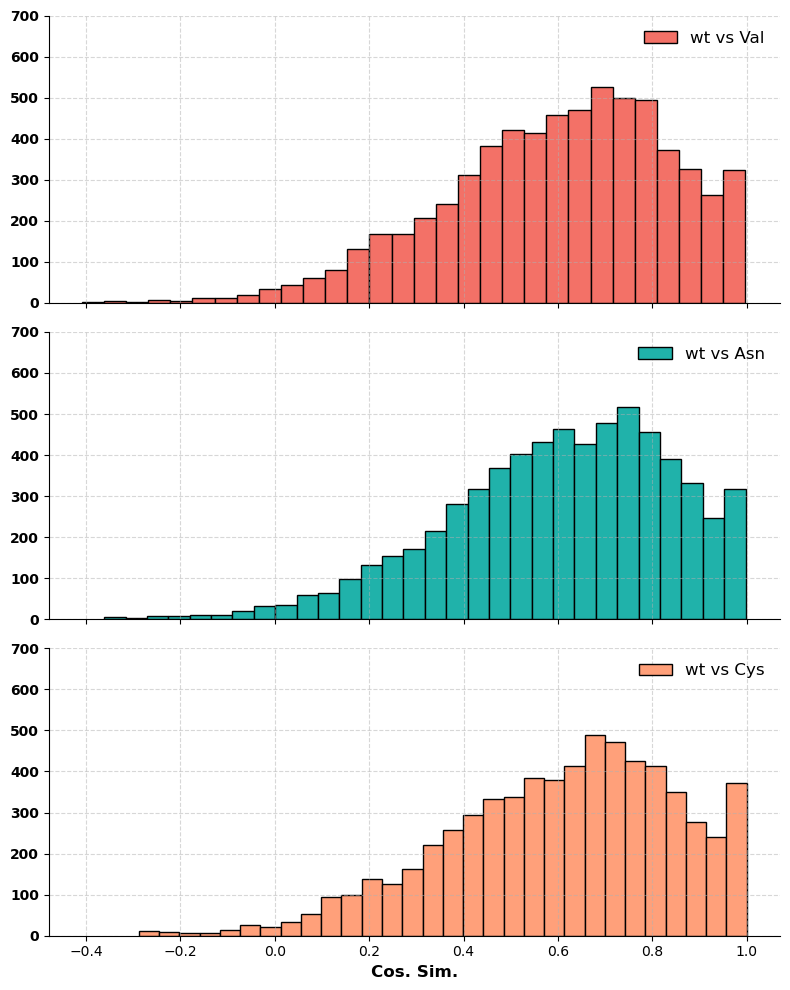

In [571]:
###入力配列を変更した際の出力dG行列変化を可視化する###

cos_sim_list_wt_val = []
cos_sim_list_wt_asn = []
cos_sim_list_wt_cys = []

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for npy_file, npy_file_Val, npy_file_Asn, npy_file_Cys in zip(glob.glob('../processed_data/wt_dG_mat/*.npy'), glob.glob('../processed_data/wt_dG_mat_poly_Val/*.npy'), glob.glob('../processed_data/wt_dG_mat_poly_Asn/*.npy'), glob.glob('../processed_data/wt_dG_mat_poly_Cys/*.npy')):
    pdb_file = npy_file.replace('_res_wise_dG.npy', '.pdb').replace('wt_dG_mat', 'Mega_mt_pdb')
    seq = get_sequence_from_single_chain_pdb(pdb_file)
    npy_file_label = npy_file.split('/')[-1].replace('_res_wise_dG.npy', '')

    for aa_vec, aa_vec_Val, aa_vec_Asn, aa_vec_Cys in zip(np.load(npy_file), np.load(npy_file_Val), np.load(npy_file_Asn), np.load(npy_file_Cys)):
        cos_sim_Val = cos_sim(aa_vec, aa_vec_Val)
        cos_sim_Asn = cos_sim(aa_vec, aa_vec_Asn)
        cos_sim_Cys = cos_sim(aa_vec, aa_vec_Cys)

        cos_sim_list_wt_val.append(cos_sim_Val)
        cos_sim_list_wt_asn.append(cos_sim_Asn)
        cos_sim_list_wt_cys.append(cos_sim_Cys)


data_lists = [cos_sim_list_wt_val, cos_sim_list_wt_asn, cos_sim_list_wt_cys]


fig, axes = plt.subplots(nrows=len(data_lists), ncols=1, figsize=(8, 10), sharex=True)

for i, (bins, ax, color, dataset_label) in enumerate(zip([30,30,30], axes, [ '#F37167', '#20B2AA', '#FFA07A'], ['wt vs Val', 'wt vs Asn', 'wt vs Cys'])):
    ax.hist(data_lists[i], bins=bins, color=color, edgecolor='black', density=False, label=dataset_label)
    ax.set_ylim(0, 700)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=12, frameon=False)

# x軸ラベル（共通）
axes[-1].set_xlabel("Cos. Sim.", fontsize=12, fontweight='bold')
fig.tight_layout()
sns.despine()
plt.savefig('../Figures/cosine_similarity_wt_vs_mutants_histogram.png', dpi=300, bbox_inches='tight')



In [15]:
hydrophilic_aas = ['D', 'E', 'K', 'R', 'N', 'Q', 'S', 'T', 'H']
hydrophobic_aas = ['A', 'V', 'L', 'I', 'M', 'F',]
amphipathic_aas = ['Y', 'W',]

hydrophilic_burial_deg_and_dG = {'burial_deg': [], 'dG': []}
hydrophobic_burial_deg_and_dG = {'burial_deg': [], 'dG': []}
cys_burial_deg_and_dG = {'burial_deg': [], 'dG': []}
amphipathic_burial_deg_and_dG = {'burial_deg': [], 'dG': []}

for npy_file in tqdm.tqdm(glob.glob('../processed_data/wt_dG_mat/*.npy')):
    pdb_file = npy_file.replace('_res_wise_dG.npy', '.pdb').replace('wt_dG_mat', 'Mega_mt_pdb')
    seq = get_sequence_from_single_chain_pdb(pdb_file)
    
    rASA_list = compute_rasa(pdb_file)
    
    for aa_wise_dG, rASA in zip(np.load(npy_file), rASA_list.values()):
        for aa in list("ACDEFGHIKLMNPQRSTVWY"):
            if aa in hydrophilic_aas:
                hydrophilic_burial_deg_and_dG['burial_deg'].append(rASA)
                hydrophilic_burial_deg_and_dG['dG'].append(aa_wise_dG[list("ACDEFGHIKLMNPQRSTVWY").index(aa)])
            elif aa in hydrophobic_aas:
                hydrophobic_burial_deg_and_dG['burial_deg'].append(rASA)
                hydrophobic_burial_deg_and_dG['dG'].append(aa_wise_dG[list("ACDEFGHIKLMNPQRSTVWY").index(aa)])
            elif aa == 'C':
                cys_burial_deg_and_dG['burial_deg'].append(rASA)
                cys_burial_deg_and_dG['dG'].append(aa_wise_dG[list("ACDEFGHIKLMNPQRSTVWY").index(aa)])
            elif aa in amphipathic_aas:
                amphipathic_burial_deg_and_dG['burial_deg'].append(rASA)
                amphipathic_burial_deg_and_dG['dG'].append(aa_wise_dG[list("ACDEFGHIKLMNPQRSTVWY").index(aa)])







100%|██████████| 140/140 [00:02<00:00, 57.42it/s]


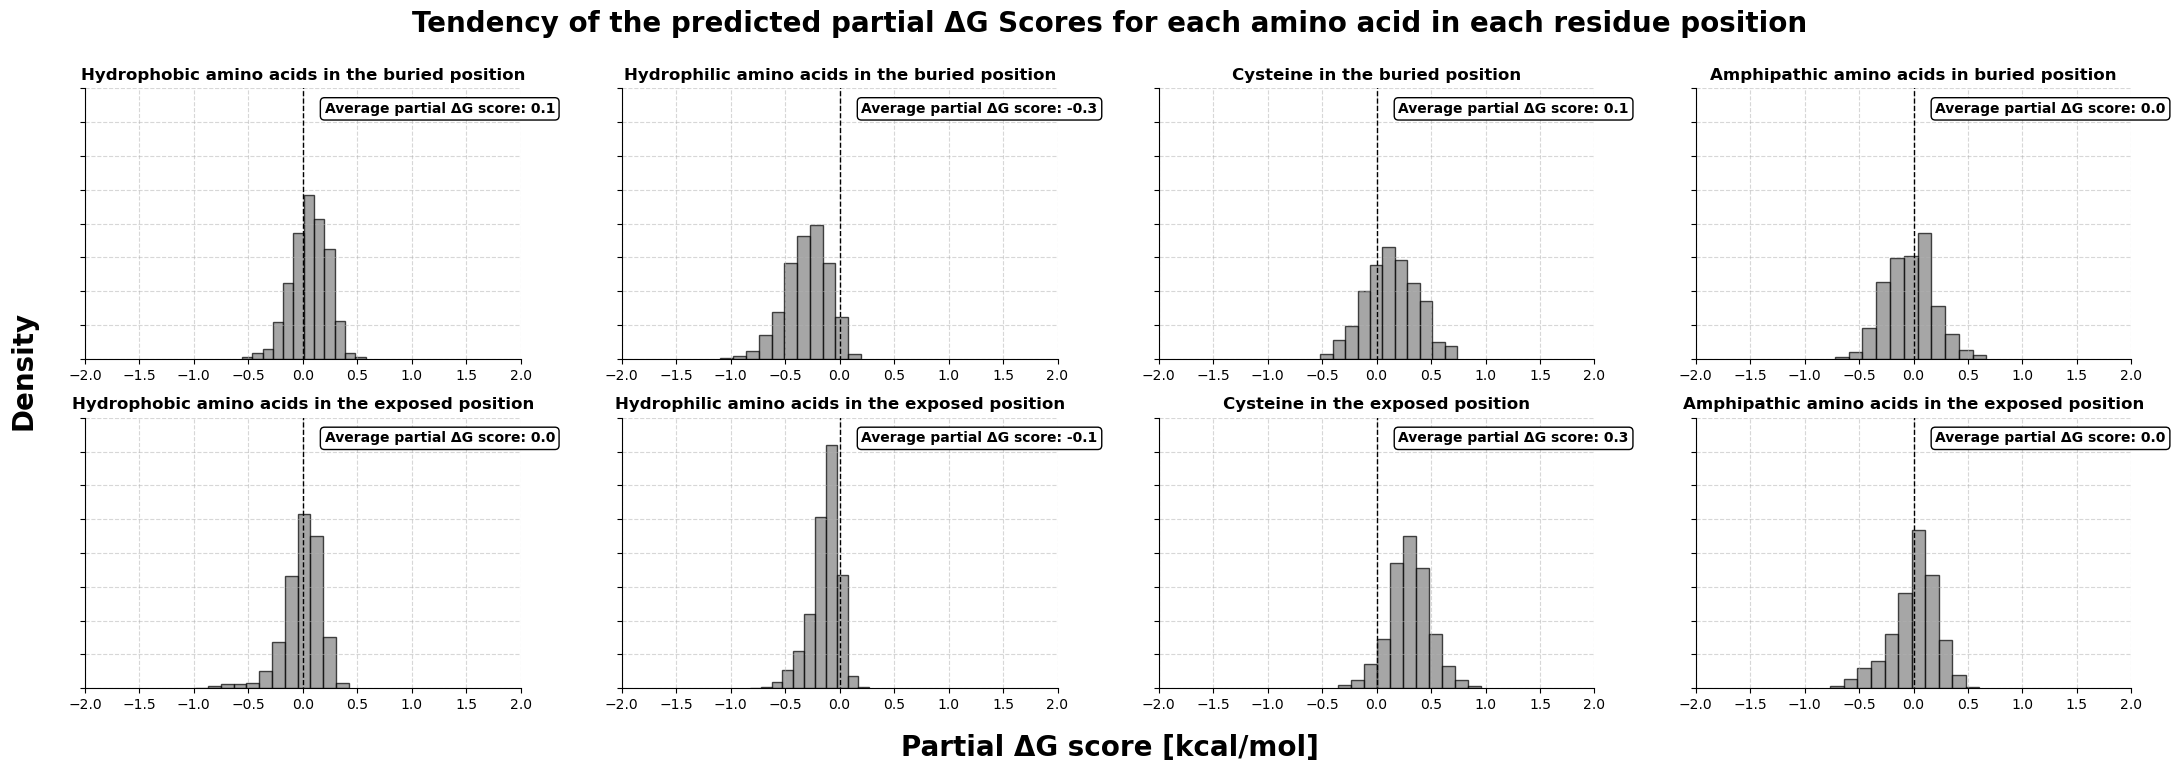

In [32]:
H_B = []
H_E = []
P_B = []
P_E = []
C_B = []
C_E = []
A_B = []
A_E = []
burial_threshold = 0.16
exposed_threshold = 0.16
for deg, dG in zip(hydrophilic_burial_deg_and_dG['burial_deg'], hydrophilic_burial_deg_and_dG['dG']):
    if deg <= burial_threshold:
        P_B.append(dG)
    elif deg > exposed_threshold:
        P_E.append(dG)
for deg, dG in zip(hydrophobic_burial_deg_and_dG['burial_deg'], hydrophobic_burial_deg_and_dG['dG']):
    if deg <= burial_threshold:
        H_B.append(dG)
    elif deg > exposed_threshold:
        H_E.append(dG)
for deg, dG in zip(cys_burial_deg_and_dG['burial_deg'], cys_burial_deg_and_dG['dG']):
    if deg <= burial_threshold:
        C_B.append(dG)
    elif deg > exposed_threshold:
        C_E.append(dG)
for deg, dG in zip(amphipathic_burial_deg_and_dG['burial_deg'], amphipathic_burial_deg_and_dG['dG']):
    if deg <= burial_threshold:
        A_B.append(dG)
    elif deg > exposed_threshold:
        A_E.append(dG)



list1 = H_B
list2 = P_B
list3 = C_B
list4 = A_B
list5 = H_E
list6 = P_E
list7 = C_E
list8 = A_E

data_lists = [list1, list2, list3, list4, list5, list6, list7, list8]

label_list = ['Hydrophobic amino acids in the buried position', 'Hydrophilic amino acids in the buried position', 'Cysteine in the buried position', 'Amphipathic amino acids in buried position', 'Hydrophobic amino acids in the exposed position', 'Hydrophilic amino acids in the exposed position', 'Cysteine in the exposed position', 'Amphipathic amino acids in the exposed position']

# 2行×2列のサブプロット
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 8))

# axes を平坦化して for で一括処理
axes_flat = axes.flatten()

for i, (ax, bin) in enumerate(zip(axes_flat, [12, 11, 11, 11, 12, 11, 11, 11])):
    average_value = np.mean(data_lists[i])
    if average_value<0 and average_value>-0.05:
        average_value = 0.0
    ax.hist(data_lists[i], bins=bin,
            color='gray', edgecolor='black', density=True, alpha=0.7)
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 4.0)
    ax.set_title(label_list[i], fontsize=12, fontweight='bold')
    ax.set_yticklabels([])
    
    ax.text(
        .55, 0.95,
        f'Average partial ΔG score: {average_value:.1f}',
        transform=ax.transAxes,
        fontsize=10, fontweight='bold',
        va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    ax.plot([0,0], [-100, 100], alpha=1, linestyle='--', linewidth=1, color='k')
    ax.grid(True, linestyle='--', alpha=0.5)

fig.suptitle("Tendency of the predicted partial ΔG Scores for each amino acid in each residue position", fontsize=20, fontweight='bold', y=0.95)
fig.supxlabel("Partial ΔG score [kcal/mol]", fontsize=20, fontweight='bold')
fig.supylabel("Density", fontsize=20, fontweight='bold', x=0.0)
plt.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()
plt.savefig('../Figures/dG_score_distribution_by_burial_degree_and_AA_type.png', dpi=300, bbox_inches='tight')
plt.show()


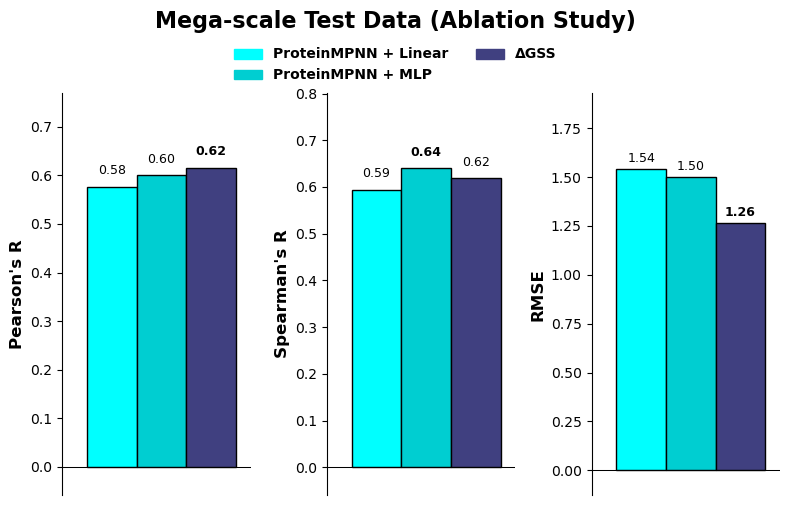

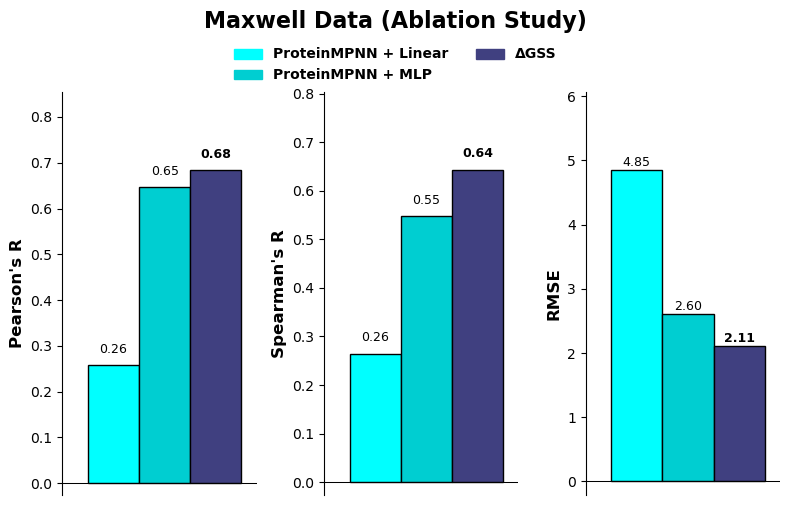

In [ ]:
###Attention -> MLP or Linear: Ablation studyによる性能比較###

# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R', 'RMSE']
method0 = [0.5763242313137507, 0.5938524985987265, 1.543638825416565]
method1 = [0.6000110156644716, 0.6405601135589751, 1.5031546354293823]
method2 = [0.61526301642787, 0.6185661286736823, rmse2_Mega]
methods = ["ProteinMPNN + Linear", "ProteinMPNN + MLP", model_name]
colors = ['cyan', 'darkturquoise', '#f6adc6']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m1, m2) in enumerate(zip(axes, metrics, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 1.  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    ax.plot([-100, 100], [0.0, 0.0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[2], label=methods[2], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-min(m0, m1, m2) * 0.1, max(m0, m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if i == 0 and bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif i == 1 and bar_ind == 1:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif i == 2 and bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(3)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data (Ablation Study)', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_of_ablation_study_on_Mega_test_data.png', dpi=300, bbox_inches='tight')
plt.show()



# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R', 'RMSE']
method0 = [0.25728611455613914, 0.2636189532117518, 4.853124141693115]
method1 = [0.6468216627149741, 0.5474952299309487, 2.6014535427093506]
method2 = [0.6838274533379817, 0.6427593999389338, rmse2_Maxwell]
methods = ["ProteinMPNN + Linear", "ProteinMPNN + MLP", model_name]
colors = ['cyan', 'darkturquoise', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m1, m2) in enumerate(zip(axes, metrics, method0 ,method1, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 1.  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m1], width=width, color=colors[1], label=methods[1], edgecolor='black')
    bars2 = ax.bar(x + offset/2, [m2], width=width, color=colors[2], label=methods[2], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-min(m0, m1, m2) * 0.1, max(m0, m1, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 2:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(3)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data (Ablation Study)', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_of_ablation_study_on_Maxwell_test_data.png', dpi=300, bbox_inches='tight')
plt.show()

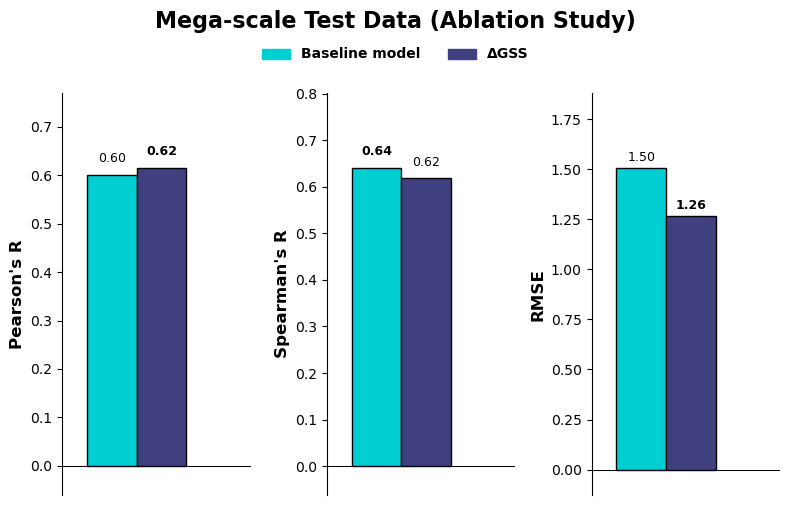

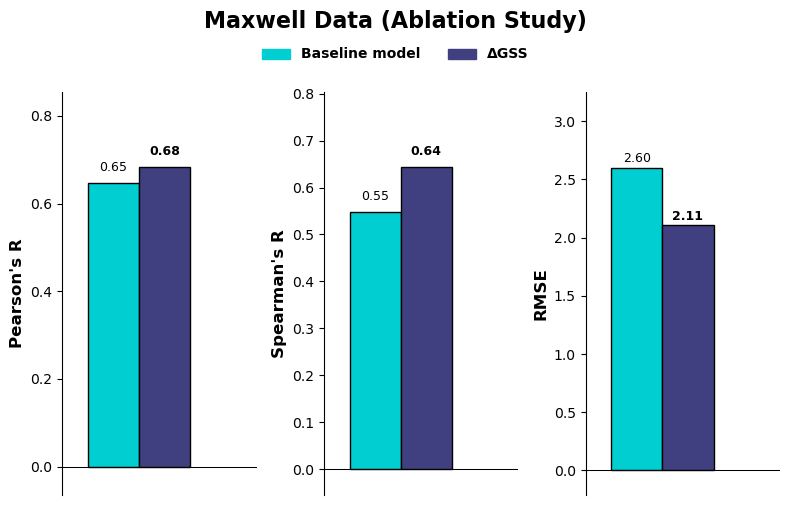

In [35]:
###Attention -> MLP or Linear: Ablation studyによる性能比較###

# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R', 'RMSE']
method0 = [0.6000110156644716, 0.6405601135589751, 1.5031546354293823]
method2 = [0.61526301642787, 0.6185661286736823, rmse2_Mega]
methods = ["Baseline model", model_name]
colors = ['darkturquoise', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m2) in enumerate(zip(axes, metrics, method0, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 1.  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    ax.plot([-100, 100], [0.0, 0.0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m2], width=width, color=colors[1], label=methods[1], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-min(m0, m2) * 0.1, max(m0, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 1 and metric in ['Pearson\'s R', 'RMSE']:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif bar_ind == 0 and metric not in ['Pearson\'s R', 'RMSE']:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(2)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data (Ablation Study)', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_of_ablation_study_on_Mega_test_data.png', dpi=300, bbox_inches='tight')
plt.show()



# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'Spearman\'s R', 'RMSE']
method0 = [0.6468216627149741, 0.5474952299309487, 2.6014535427093506]
method2 = [0.6838274533379817, 0.6427593999389338, rmse2_Maxwell]
methods = ["Baseline model", model_name]
colors = ['darkturquoise', '#404080']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(8, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m2) in enumerate(zip(axes, metrics, method0 , method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 1.  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m2], width=width, color=colors[1], label=methods[1], edgecolor='black')


    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-min(m0, m2) * 0.1, max(m0, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 1:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(2)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data (Ablation Study)', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_of_ablation_study_on_Maxwell_test_data.png', dpi=300, bbox_inches='tight')
plt.show()

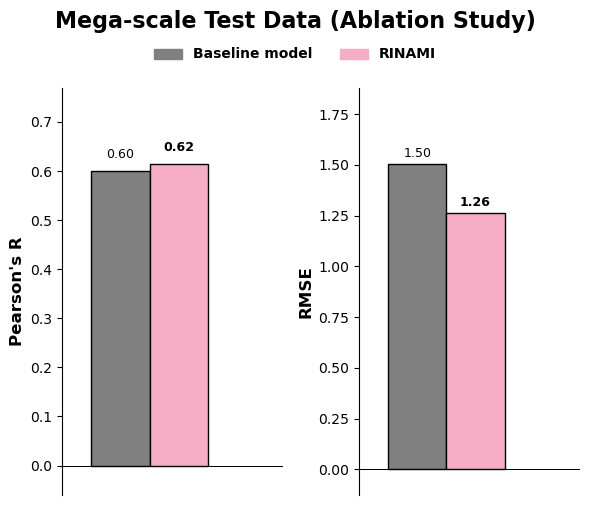

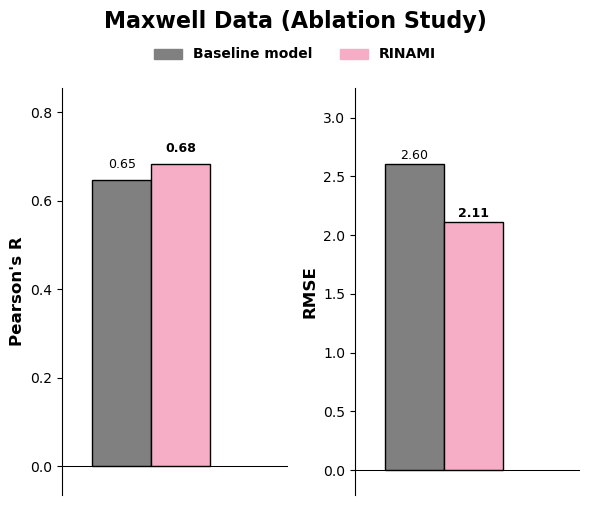

In [16]:
###Attention -> MLP or Linear: Ablation studyによる性能比較###

# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'RMSE']
method0 = [0.6000110156644716, 1.5031546354293823]
method2 = [0.61526301642787, rmse2_Mega]
methods = ["Baseline model", model_name]
colors = ['gray', '#f6adc6']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(6, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m2) in enumerate(zip(axes, metrics, method0, method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 1.  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    ax.plot([-100, 100], [0.0, 0.0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m2], width=width, color=colors[1], label=methods[1], edgecolor='black')

    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-min(m0, m2) * 0.1, max(m0, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 1 and metric in ['Pearson\'s R', 'RMSE']:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            elif bar_ind == 0 and metric not in ['Pearson\'s R', 'RMSE']:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(2)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Mega-scale Test Data (Ablation Study)', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_of_ablation_study_on_Mega_test_data.png', dpi=300, bbox_inches='tight')
plt.show()



# --- 評価指標と値 ---
metrics = ['Pearson\'s R', 'RMSE']
method0 = [0.6468216627149741, 2.6014535427093506]
method2 = [0.6838274533379817, rmse2_Maxwell]
methods = ["Baseline model", model_name]
colors = ['gray', '#f6adc6']

# --- Figureを作成（横に3つ並べる） ---
fig, axes = plt.subplots(1, len(metrics), figsize=(6, 5))
fig.subplots_adjust(wspace=0.4)

for i, (ax, metric, m0, m2) in enumerate(zip(axes, metrics, method0 , method2)):
    # x軸の中心を共通にして、バーを軽く重ねるように調整
    x = np.arange(1)
    offset = 1.  # 棒の間隔を狭くする（小さいほどくっつく）
    width = 0.5

    ax.plot([-100, 100], [0, 0], c='k', linewidth=0.75)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    bars0 = ax.bar(x - offset/2, [m0], width=width, color=colors[0], label=methods[0], edgecolor='black')
    bars1 = ax.bar(x           , [m2], width=width, color=colors[1], label=methods[1], edgecolor='black')


    # 軸設定
    ax.set_ylabel(metric,
                  fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlim(-1, 0.9)
    ax.set_ylim(-min(m0, m2) * 0.1, max(m0, m2) * 1.25)

    # 棒の上に値を表示
    for bar_ind, bars in enumerate([bars0, bars1]):
        for bar in bars:
            height = bar.get_height()
            if bar_ind == 1:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
# --- 共通凡例 ---
handles = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(2)]
labels = methods
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=11, frameon=False, bbox_to_anchor=(0.5, .95), prop={'weight':'bold'})

# --- 共通タイトル ---
fig.suptitle('Maxwell Data (Ablation Study)', fontsize=16, fontweight='bold', y=1.)

##sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../Figures/Bar_Comparison_of_ablation_study_on_Maxwell_test_data.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
test_result_baseline_f = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/test_result_baseline.txt'
test_result_dGSS_f = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/test_result.txt'

test_result_baseline_e = []
test_result_dGSS_e = []

with open(test_result_baseline_f, 'r') as f:
    for line in f:
        e = abs(float(line.strip().split()[0]) - float(line.strip().split()[1]))
        test_result_baseline_e.append(e)
with open(test_result_dGSS_f, 'r') as f:
    for line in f:
        e = abs(float(line.strip().split()[0]) - float(line.strip().split()[1]))
        test_result_dGSS_e.append(e)

stat_Mega_e, p_value_Mega_e = wilcoxon(
    test_result_baseline_e,
    test_result_dGSS_e,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)

print('P=',p_value_Mega_e)

P= 1.491524054800285e-233


Text(0, 0.5, 'Absolute Error by dGSS model [kcal/mol]')

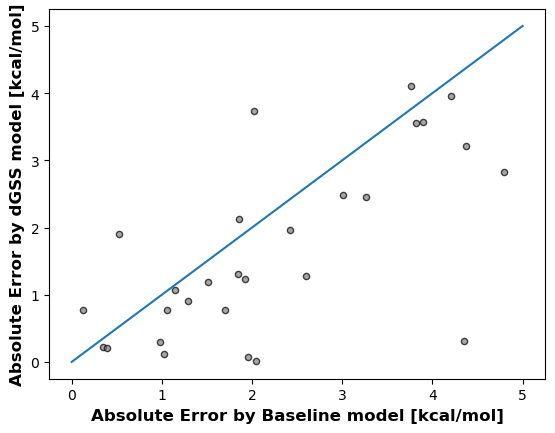

In [32]:
plt.scatter(test_result_baseline_e, test_result_dGSS_e,
            color='gray', edgecolor='k', alpha=0.7, s=20)
plt.plot([0, 5], [0, 5])
plt.xlabel('Absolute Error by Baseline model [kcal/mol]', fontsize=12, fontweight='bold')
plt.ylabel('Absolute Error by dGSS model [kcal/mol]', fontsize=12, fontweight='bold')

In [27]:
test_result_baseline_f = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/maxwell_test_temp_baseline.txt'
test_result_dGSS_f = '/Users/tomitanaoki/Desktop/Projects/dG_predictor_from_ProteinMPNN_likelihood/processed_data/maxwell_test_temp.txt'

test_result_baseline_e = []
test_result_dGSS_e = []

with open(test_result_baseline_f, 'r') as f:
    for line in f:
        e = abs(float(line.strip().split()[0]) - float(line.strip().split()[1]))
        test_result_baseline_e.append(e)
with open(test_result_dGSS_f, 'r') as f:
    for line in f:
        e = abs(float(line.strip().split()[0]) - float(line.strip().split()[1]))
        test_result_dGSS_e.append(e)

stat_Mega_e, p_value_Mega_e = wilcoxon(
    test_result_baseline_e,
    test_result_dGSS_e,
    zero_method='wilcox',      # ゼロ差を除外
    alternative='two-sided',   # 両側検定
    correction=False,          # 連続性の補正なし
    method='auto'        # method{“auto”,“exact”,“asymptotic”}
)

print('P=',p_value_Mega_e)

P= 0.004113913713980743
